# **Intro M2**
In this notebook I set up semi-supervised VAE to predict cell type proportions from bulk data.
This is the M2 model structure.
This is almost identical to "[DIVA: DOMAIN INVARIANT VARIATIONAL AUTOENCODERS](https://arxiv.org/pdf/1905.10427.pdf)".
To breifly describe the model, we have 3 independent encoders that encode for different sources of variation: cell-type proportion, sample-id, and everything else (slack).
To enforce this disentanglement, there are classification losses on the cell-type and smaple_id embeddings.
The embeddings are then concatenated together and used as input to a joint decoder.
When used in the no label is available for the cell-type proportion, the output of the classifier is used as the latent code.
When it is available, it is directly input into the latent code.
The model is depicted below, except there is an additional latent subspace for predicting the perturbation status.
This latent subspace is structured in the same was as the encoder for sample_id.



The experimental set-up is as follows:
All data is from Kang dataset.
We generate pesudobulks from the original data, which contains 8 samples and 1 stimulated and one ctrl condition per sample.
We either perturb all cells, a single cell-type, or no cell types. 
This is done when we generate the pseudobulks by sampling from either perturbed or non-perturbed cells within each sample.
This is denoted in the parameter `exp_id`, it can be "all-kang", "mono-kang", "b-kang", "cd4Naive-kang", or "none-kang"
This is like a perturbation that would cause one cell type to change.
We use 2 samples as the "labeled" data (meaning each sample has a ground truth cell-type proportion and it is from the cell-type proportion) and 6 samples with unlabeled data (ground truth proportions are not used in training.)




This code was based off of DIVA's codebase: https://github.com/AMLab-Amsterdam/DIVA

Semi-supervised training method was take from here:
And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/

Another codebase referenced: https://github.com/saemundsson/semisupervised_vae


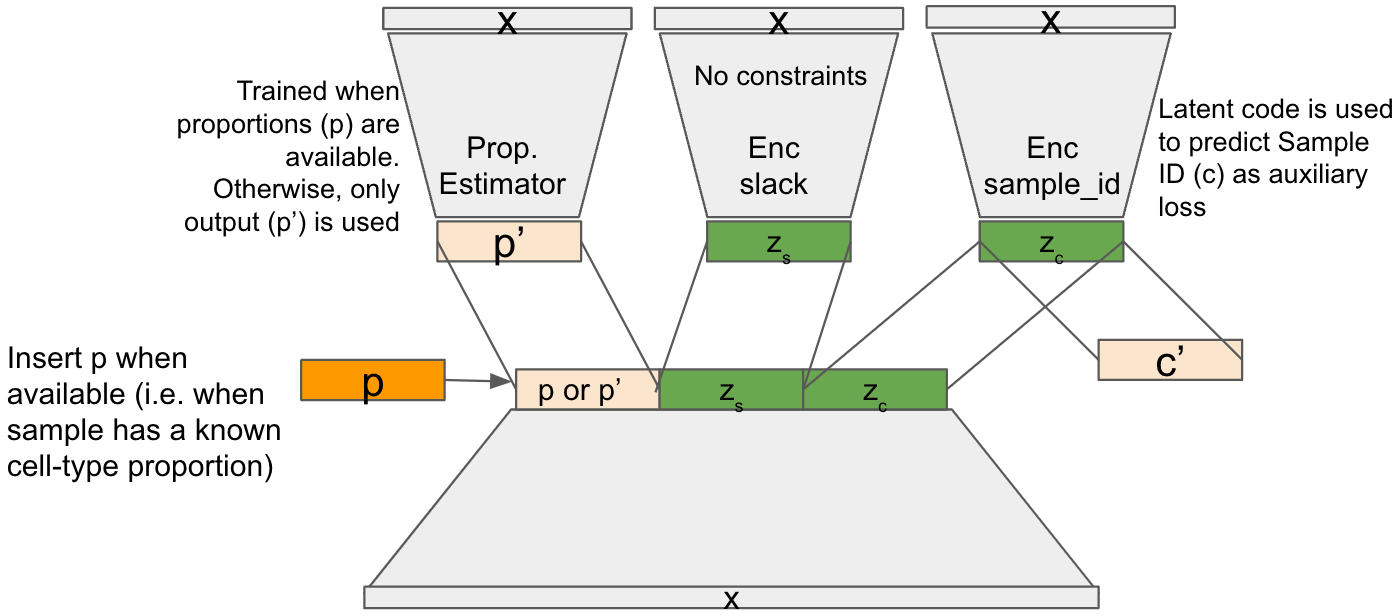

# **Imports**

In [1]:
# general imports
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from tensorflow.keras.layers import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error, KLDivergence
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr, ttest_ind, wilcoxon
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

from tqdm import tnrange, tqdm_notebook
import ipywidgets

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# import the SC_preprocessing code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess
from method_comparison import validation_plotting as vp


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [2]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [3]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)
reload(vp)

<module 'method_comparison.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/exploratory_experiments/../method_comparison/validation_plotting.py'>

In [4]:
## parameters
aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_kang_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_kang/"
cibersort_genes_path = (f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/" +
                        "CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_refsample.bm.K999.txt")

# cibersort results
cibersort_file_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/CIBERSORTx_Job18_Results.csv"

# bp results
bp_res_path = f"{os.getcwd()}/../results/single_cell_data/bp_kang/"

# DiffExp results
de_res_path = f"{os.getcwd()}/../data/single_cell_data/kang_rybakov/kang_DE_paper.tsv"

num_genes = 7000

exp_id = "mono-kang"

# Set-up experimental variables

In [5]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 10

# number of patients/domains/samples expected
idx_range = range(0, 16)
n_tot_samples = 8 # 8 patients, 2 samples each

# number of drugs (one-hot encoded)
n_drugs = 2

# experiment id
lab_file_name = exp_id


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [6]:

##################################################
#####. Design the experiment
##################################################

# read in the labeled data
X_full, Y_full, gene_df, meta_df = sc_preprocess.read_all_kang_pseudobulk_files(aug_data_path, exp_id, num_bulks_training=10)
X_full.columns = gene_df

X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]

# only get genes that are available in both testing and training
common_genes_file = os.path.join(aug_data_path, "kang_genes.pkl")
gene_out_path = Path(common_genes_file)
common_genes = pickle.load(open( gene_out_path, "rb" ))

# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(common_genes, cibersort_genes)

X_train_df = X_train_df[common_genes]

gene_df = gene_df.loc[gene_df.isin(common_genes)]


# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -num_genes)[-num_genes:]
gene_df = gene_df.iloc[idx_top]


1488
STIM
Train
Test
CTRL
Train
Test
1244
STIM
Train
Test
CTRL
Train
Test
1016
STIM
Train
Test
CTRL
Train
Test
101
STIM
Train
Test
CTRL
Train
Test
1039
STIM
Train
Test
CTRL
Train
Test
107
STIM
Train
Test
CTRL
Train
Test


In [7]:
X_train_df

gene_ids LINC00115 NOC2L KLHL17 PLEKHN1 HES4  ISG15 AGRN C1orf159 TNFRSF18  \
0              165   510      8      51  875  15392    0       52      405   
0              142   932      2     596  216   9662    0       44      566   
0              506  1584      0    1131   68  13818    0       86      537   
0              255  1371      0     603  402  11352    0      123     1006   
0               84  1291      4     311  486   8505    0       29      781   
..             ...   ...    ...     ...  ...    ...  ...      ...      ...   
0               35   305      0     128   31   1352    0        0      163   
0               26   279      0      65   26   1460    0        0      171   
0               11   253      0      96  153   1231    0        0      329   
0               36   235      0     189   18   1292    0        0      130   
0               44   325      0     180   66   1620    0        0      271   

gene_ids TNFRSF4  ... CPT1B AF127936.5 AJ006998.2 CHODL AP000476.1 LINC00158  \
0           1289  ...     0          0          0     0          0         0   
0           5343  ...     0          0          0     0          0         0   
0          13384  ...     0          0          0     0          0         0   
0           8208  ...     0          0          0     0          0         0   
0           3081  ...     0          0          0     0          0         0   
..           ...  ...   ...        ...        ...   ...        ...       ...   
0             71  ...     0          0          0     0          0         0   
0            182  ...     0          0          0     0          0         0   
0            154  ...     0          0          0     0          0         0   
0             85  ...     0          0          0     0          0         0   
0             70  ...     0          0          0     0          0         0   

gene_ids AF131217.1 AP001437.1 TMPRSS3 LRRC3DN  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
..              ...        ...     ...     ...  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  

[4120 rows x 13452 columns]

In [8]:
X_train

array([[165, 510, 8, ..., 0, 0, 0],
       [142, 932, 2, ..., 0, 0, 0],
       [506, 1584, 0, ..., 0, 0, 0],
       ...,
       [11, 253, 0, ..., 0, 0, 0],
       [36, 235, 0, ..., 0, 0, 0],
       [44, 325, 0, ..., 0, 0, 0]], dtype=object)

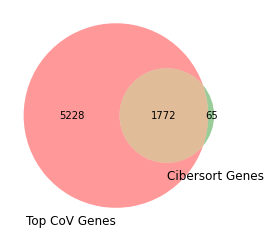

In [9]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [10]:
union_genes = np.union1d(gene_df, cibersort_genes)


In [11]:
def pearsonr_2D(x, y):
    """computes pearson correlation coefficient
       where x is a 1D and y a 2D array"""

    upper = np.sum((x - np.mean(x)) * (y - np.mean(y, axis=1)[:,None]), axis=1)
    lower = np.sqrt(np.sum(np.power(x - np.mean(x), 2)) * np.sum(np.power(y - np.mean(y, axis=1)[:,None], 2), axis=1))
    
    rho = upper / lower
    
    return rho

In [12]:
X_full = X_full.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()



[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 17320 samples in 0.070s...
[t-SNE] Computed neighbors for 17320 samples in 30.060s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17320
[t-SNE] Computed conditional probabilities for sample 2000 / 17320
[t-SNE] Computed conditional probabilities for sample 3000 / 17320
[t-SNE] Computed conditional probabilities for sample 4000 / 17320
[t-SNE] Computed conditional probabilities for sample 5000 / 17320
[t-SNE] Computed conditional probabilities for sample 6000 / 17320
[t-SNE] Computed conditional probabilities for sample 7000 / 17320
[t-SNE] Computed conditional probabilities for sample 8000 / 17320
[t-SNE] Computed conditional probabilities for sample 9000 / 17320
[t-SNE] Computed conditional probabilities for sample 10000 / 17320
[t-SNE] Computed conditional probabilities for sample 11000 / 17320
[t-SNE] Computed conditional probabilities for sample 12000 / 17320
[t-SNE] Computed conditional probabilities for sa

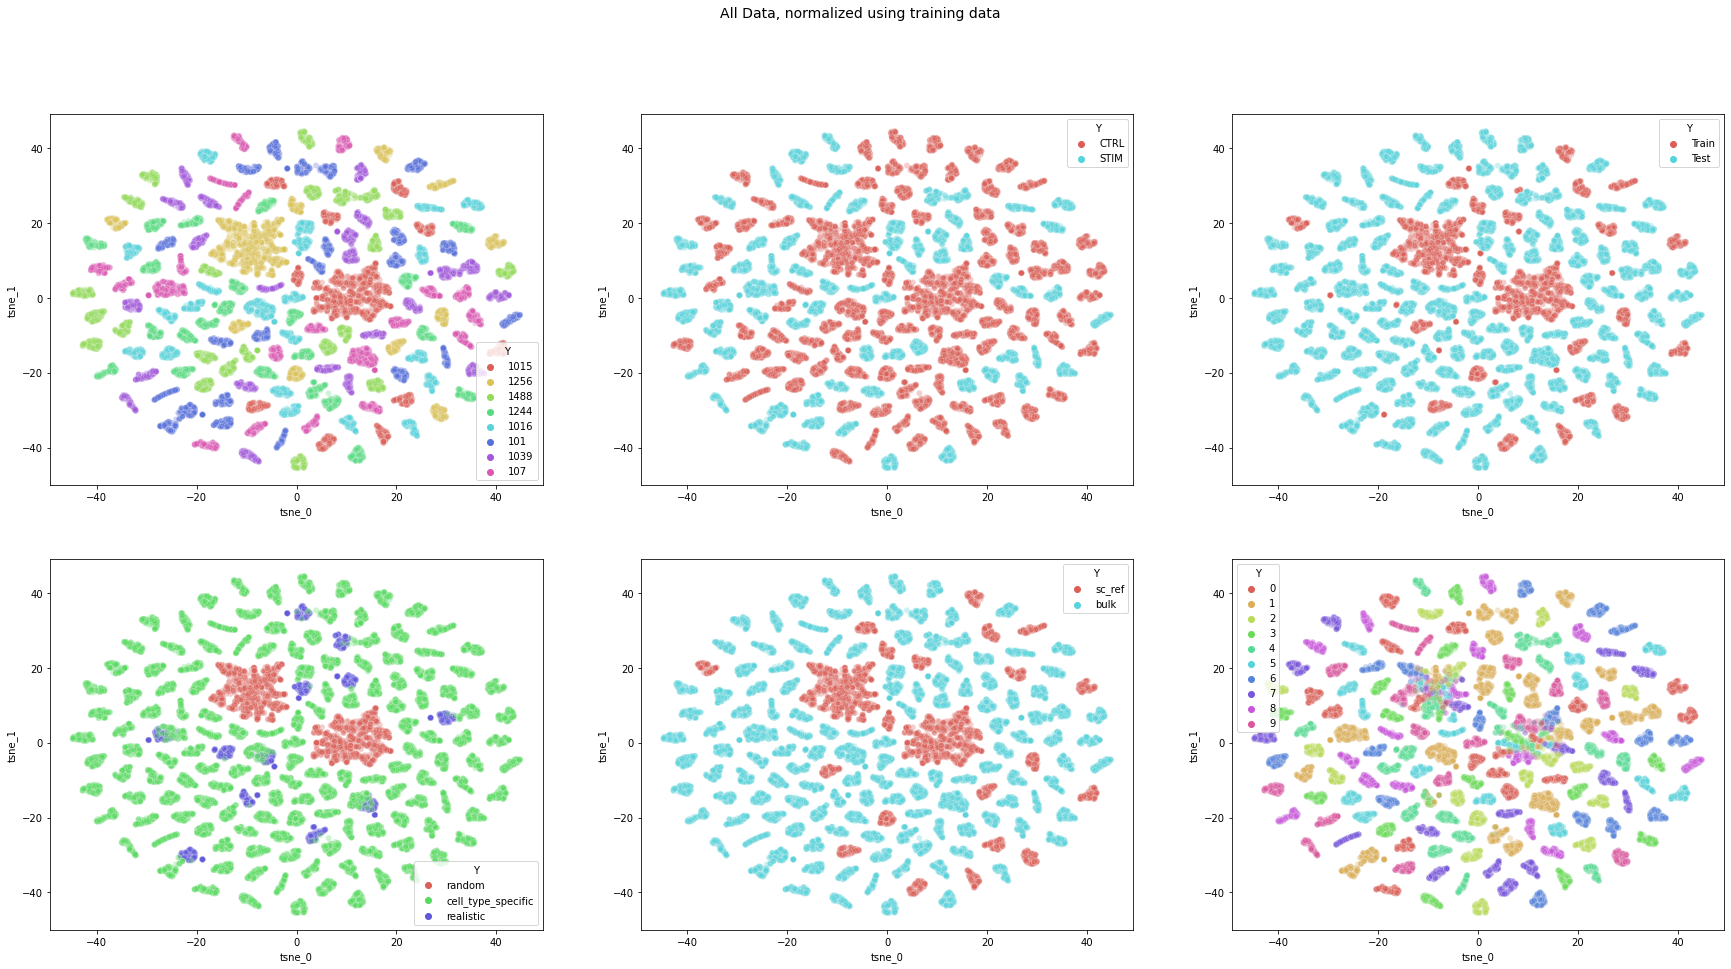

In [13]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()


(13320, 2)
(13320, 2)


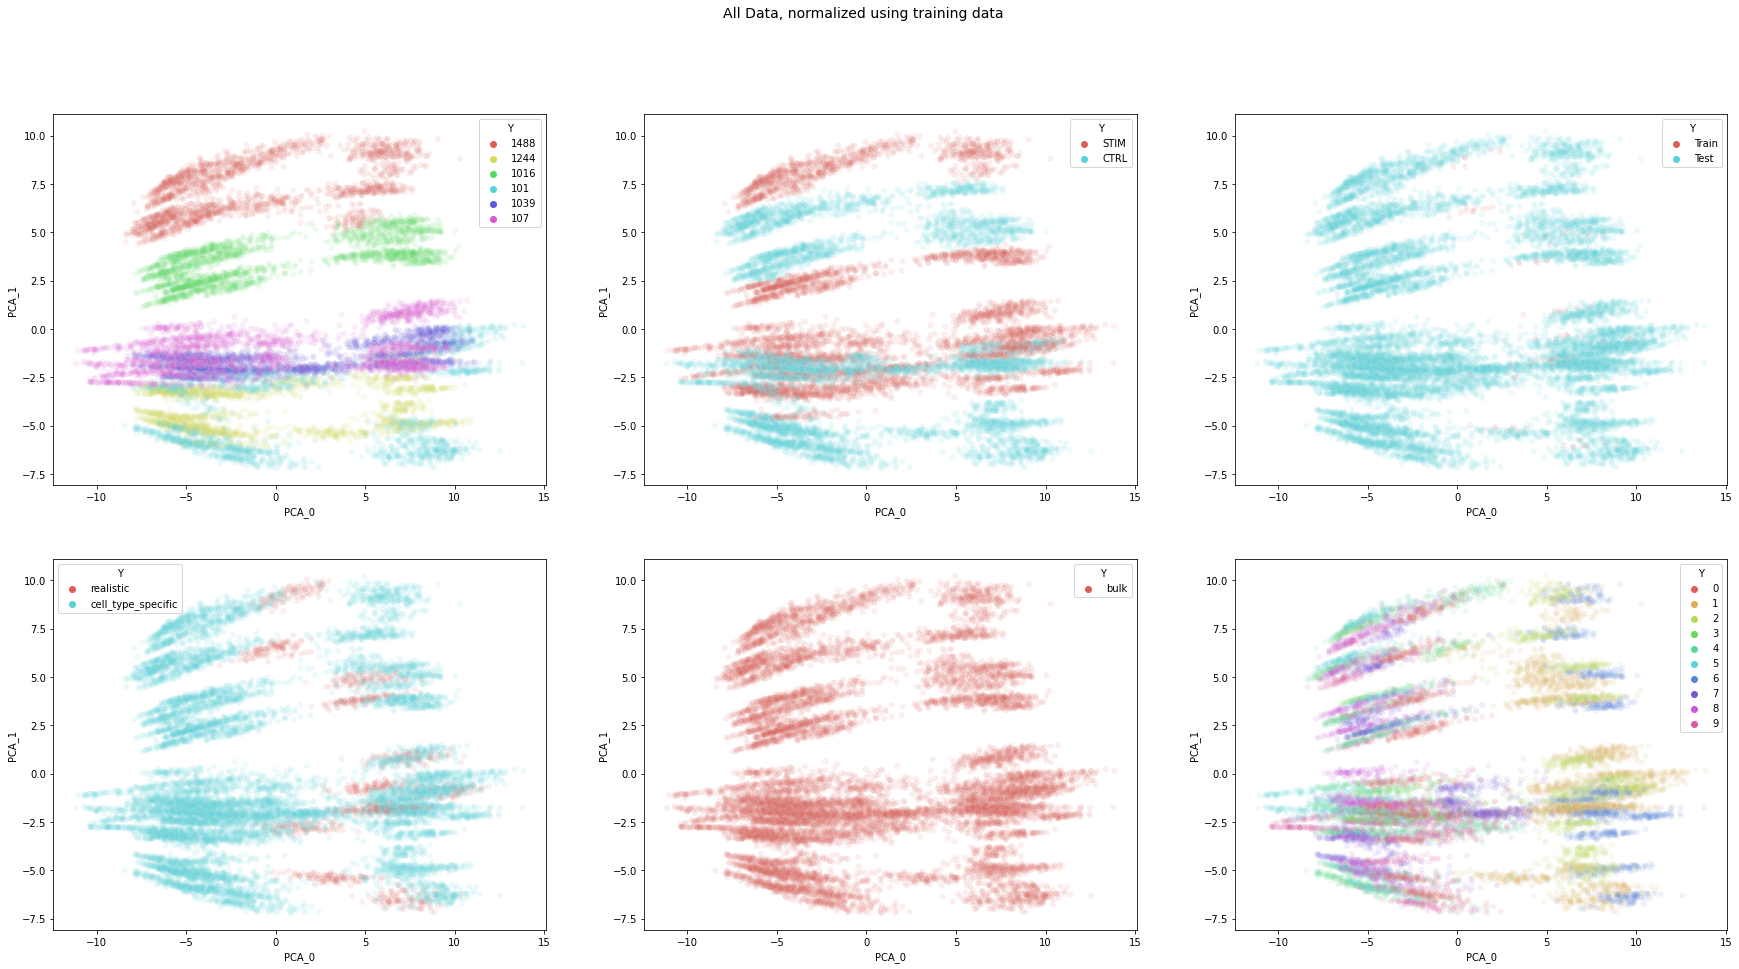

In [14]:
## plot samples
idx_interest = np.where(meta_df.samp_type == "bulk")[0]

plot_df = vp.get_pca_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"")
vp.plot_pca(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"")
vp.plot_pca(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"")
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"")
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()


(2220, 2)
(2220, 2)


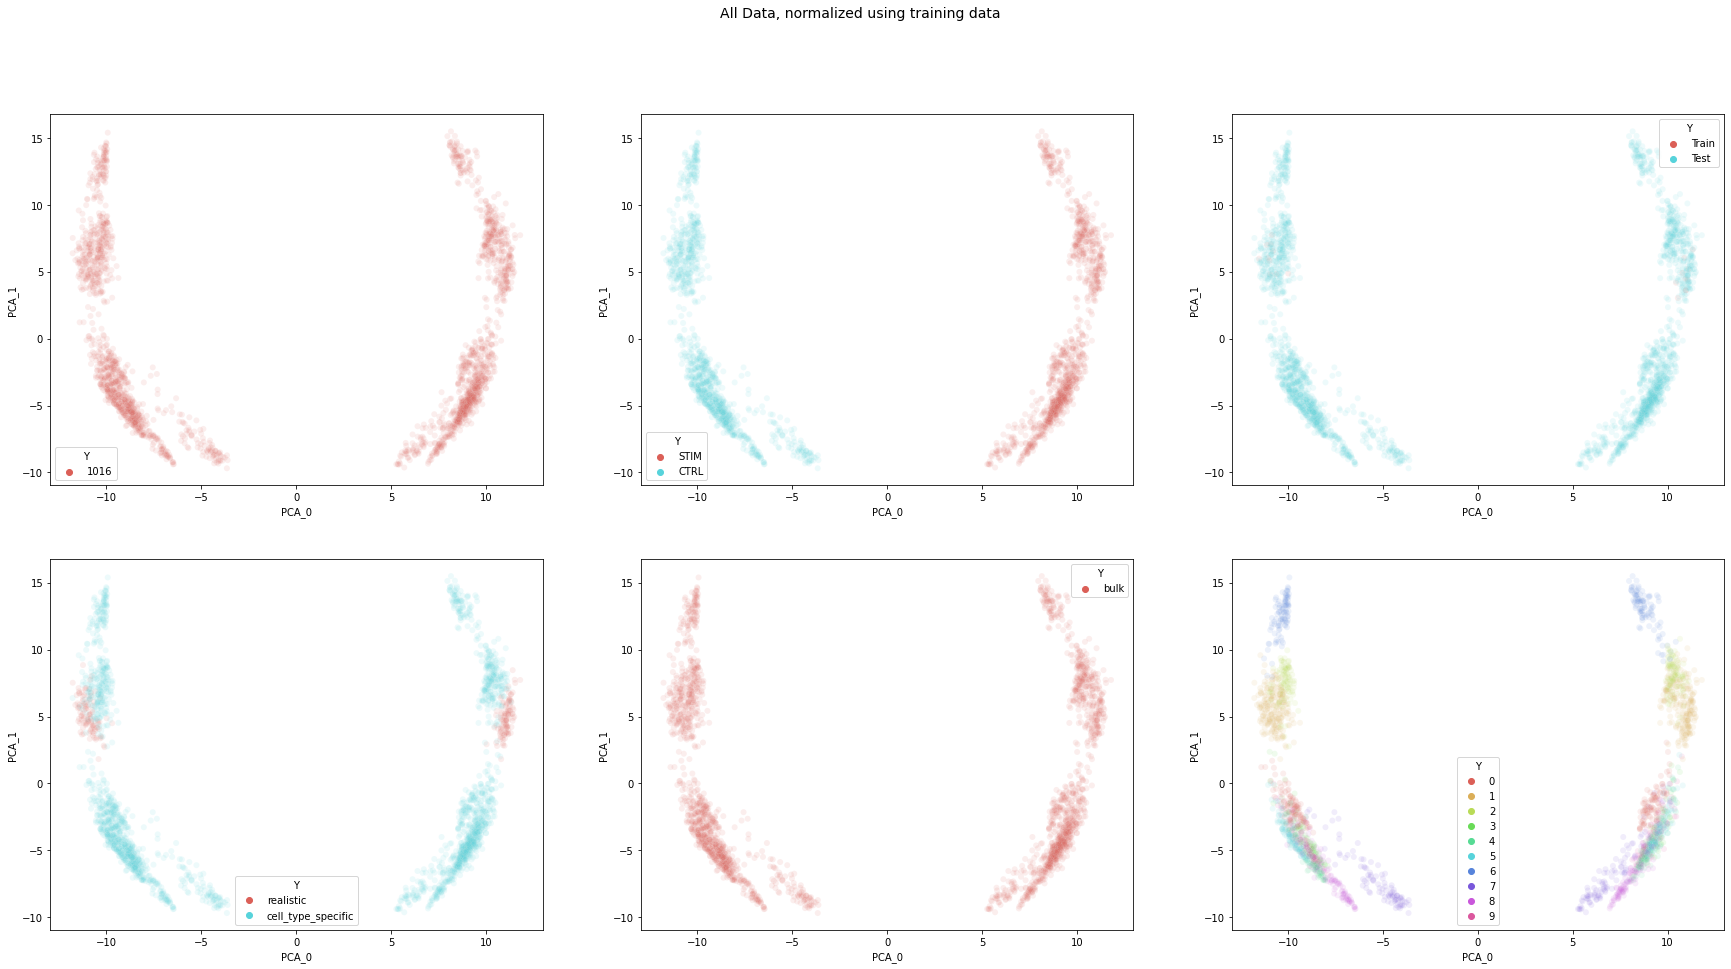

In [15]:
idx_interest = np.logical_and(meta_df.samp_type == "bulk", meta_df.sample_id == "1016")
idx_interest = np.where(idx_interest)[0]


plot_df = vp.get_pca_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"")
vp.plot_pca(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"")
vp.plot_pca(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"")
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"")
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()



In [16]:
np.random.lognormal(0, 1, 10) 

array([0.85359748, 0.76521193, 1.85971479, 0.24327096, 0.28705736,
       0.42630655, 3.81246792, 1.18971721, 0.77536969, 0.68875485])

# **M2 Model Definition**

## Hyperparameters

In [17]:

##################################################
#####. Hyperparameters
##################################################

batch_size = 500
n_epoch = 100 # 500 

alpha_rot = 1000000 #1000000
alpha_drug = 10000 #1000000
alpha_prop = 100 #100

beta_kl_slack = 0.1 # 10 ###
beta_kl_rot = 100 # 100 ###
beta_kl_drug = 100 # 100 ###


n_x = X_full.shape[1]
n_y = Y_full.shape[1]
n_label = n_tot_samples  # 8 donors 
n_drugs = n_drugs  # number of drugs one-hot encoded
n_label_z = 64  # 64 dimensional representation of rotation


# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
n_z = Y_full.shape[1] # latent space size, one latent dimension PER cell type
encoder_dim = 512 # dim of encoder hidden layer 512 
decoder_dim = 512 # dim of encoder hidden layer 512 
decoder_out_dim = n_x # dim of decoder output layer

# labeled classifier
class_dim1 = 512 # 512 
class_dim2 = 256 # 256 


activ = 'relu'
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005) #0.001
print(f"length of X {n_x} and length of y {n_y} n_label {n_label} and n_drugs {n_drugs}")



length of X 7065 and length of y 10 n_label 8 and n_drugs 2


## Encoder + Y classifier

In [18]:
# declare the Keras tensor we will use as input to the encoder
X = Input(shape=(n_x,))
Y = Input(shape=(n_y,))
label = Input(shape=(n_label,))
props = Input(shape=(n_y,))
z_in = Input(shape=(n_y+n_label_z+n_label_z+n_label_z,))
cls_in = Input(shape=(n_label_z,))

inputs = X

# set up encoder network
# this is an encoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
encoder_s = Dense(encoder_dim, activation=activ, name="encoder_slack")(inputs)
encoder_r = Dense(encoder_dim, activation=activ, name="encoder_rot")(inputs)
encoder_d = Dense(encoder_dim, activation=activ, name="encoder_drug")(inputs)

# now from the hidden layer, you get the mu and sigma for 
# the latent space

mu_slack = Dense(n_label_z, activation='linear', name = "mu_slack")(encoder_s)
l_sigma_slack = Dense(n_label_z, activation='linear', name = "sigma_slack")(encoder_s)

mu_rot = Dense(n_label_z, activation='linear', name = "mu_rot")(encoder_r)
l_sigma_rot = Dense(n_label_z, activation='linear', name = "sigma_rot")(encoder_r)


mu_drug = Dense(n_label_z, activation='linear', name = "mu_drug")(encoder_d)
l_sigma_drug = Dense(n_label_z, activation='linear', name = "sigma_drug")(encoder_d)



# set up labeled classifier
#defining the architecture of the classifier

class_hidden1 = Dense(class_dim1, activation=activ, name = "cls_h1")
class_hidden2 = Dense(class_dim2, activation=activ, name="cls_h2")
class_out = Dense(n_y, activation='softmax', name="cls_out")

#x_concat_lab = tf.keras.layers.concatenate([inputs, label])
#classifier_h1 = class_hidden1(tf.keras.layers.Concatenate()([inputs, label]))
classifier_h1 = class_hidden1(inputs)
classifier_h2 = class_hidden2(classifier_h1)
Y_cls = class_out(classifier_h2)



## Latent Space

In [19]:
# now we need the sampler from mu and sigma
def sample_z(args):
    mu, l_sigma, n_z = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z_slack = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_slack")([mu_slack, l_sigma_slack, n_label_z])
z_rot = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_rot")([mu_rot, l_sigma_rot, n_label_z])
z_drug = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_drug")([mu_drug, l_sigma_drug, n_label_z])

z_concat_lab = concat([z_slack, Y, z_rot, z_drug])
z_concat_unlab = concat([z_slack, Y_cls, z_rot, z_drug])

## Decoder + Classifiers

In [20]:
def null_f(args):
    return args

###### DECODER
# set up decoder network
# this is a decoder with 512 hidden layer
decoder_hidden = Dense(decoder_dim, activation=activ, name = "decoder_h1")

# final reconstruction
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name = "decoder_out")

d_in = Input(shape=(n_label_z+n_y+n_label_z+n_label_z,))
d_h1 = decoder_hidden(d_in)
d_out = decoder_out(d_h1)

# set up the decoder part that links to the encoder
# labeled decoder
h_lab = decoder_hidden(z_concat_lab)
outputs_lab = decoder_out(h_lab)

# unlabeled decoder
h_unlab = decoder_hidden(z_concat_unlab)
outputs_unlab = decoder_out(h_unlab)


###### Rotations classifier
# this is the rotation we try to estimate
rot_h1 = ReLU(name = "rot_h1")
rot_h2 = Dense(n_label, activation='linear', name = "rot_h2")
rot_softmax = Softmax(name = "mu_rot_pred")
decoder_sigma_r = Lambda(null_f, name = "l_sigma_rot_pred")


rot_1_out = rot_h1(z_rot)
rot_2_out = rot_h2(rot_1_out)
rotation_outputs = rot_softmax(rot_2_out)
sigma_outputs_r = decoder_sigma_r(l_sigma_rot)



###### Drug classifier
# this is the drug we try to estimate
drug_h1 = ReLU(name = "drug_h1")
drug_h2 = Dense(n_drugs, activation='linear', name = "drug_h2")
drug_softmax = Softmax(name = "mu_drug_pred")
decoder_sigma_d = Lambda(null_f, name = "l_sigma_drug_pred")


drug_1_out = drug_h1(z_drug)
drug_2_out = drug_h2(drug_1_out)
drug_outputs = drug_softmax(drug_2_out)
sigma_outputs_d = decoder_sigma_d(l_sigma_drug)








## Loss

In [21]:

def vae_loss(y_true, y_pred):
    recon = K.sum(mean_squared_error(y_true, y_pred), axis=-1)
    kl_rot = beta_kl_rot * K.sum(K.exp(l_sigma_rot) + K.square(mu_rot) - 1. - l_sigma_rot, axis=-1)
    kl_drug = beta_kl_drug * K.sum(K.exp(l_sigma_drug) + K.square(mu_drug) - 1. - l_sigma_drug, axis=-1)
    kl_slack = beta_kl_slack * K.sum(K.exp(l_sigma_slack) + K.square(mu_slack) - 1. - l_sigma_slack, axis=-1)
    return recon + kl_rot +kl_drug+ kl_slack


def recon_loss(y_true, y_pred):
	return K.sum(mean_squared_error(y_true, y_pred), axis=-1)


def prop_loss(y_true, y_pred):
  return K.sum(mean_absolute_error(y_true, y_pred), axis=-1) * alpha_prop

def drug_loss(y_true, y_pred):
  return K.sum(mean_absolute_error(y_true, y_pred), axis=-1) * alpha_drug


def class_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)*alpha_rot
    return recon



## Make the computational graph

In [22]:
classifier = Model(X, Y_cls)

known_prop_vae = Model([X, Y], [outputs_lab, Y_cls, rotation_outputs, drug_outputs])
unknown_prop_vae = Model(X, [outputs_unlab, rotation_outputs, drug_outputs])

known_prop_vae.compile(optimizer=optim, loss=[vae_loss, prop_loss, class_loss, drug_loss]) #, metrics = [KL_loss, recon_loss])
unknown_prop_vae.compile(optimizer=optim, loss=[vae_loss, class_loss, drug_loss]) #, metrics = [KL_loss, recon_loss])

encoder_unlab = Model(X, [z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug])

encoder_lab = Model([X, Y], [z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug])


decoder = Model(d_in, d_out)


print(known_prop_vae.summary())
print(unknown_prop_vae.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7065)]       0           []                               
                                                                                                  
 encoder_slack (Dense)          (None, 512)          3617792     ['input_1[0][0]']                
                                                                                                  
 encoder_rot (Dense)            (None, 512)          3617792     ['input_1[0][0]']                
                                                                                                  
 encoder_drug (Dense)           (None, 512)          3617792     ['input_1[0][0]']                
                                                                                            

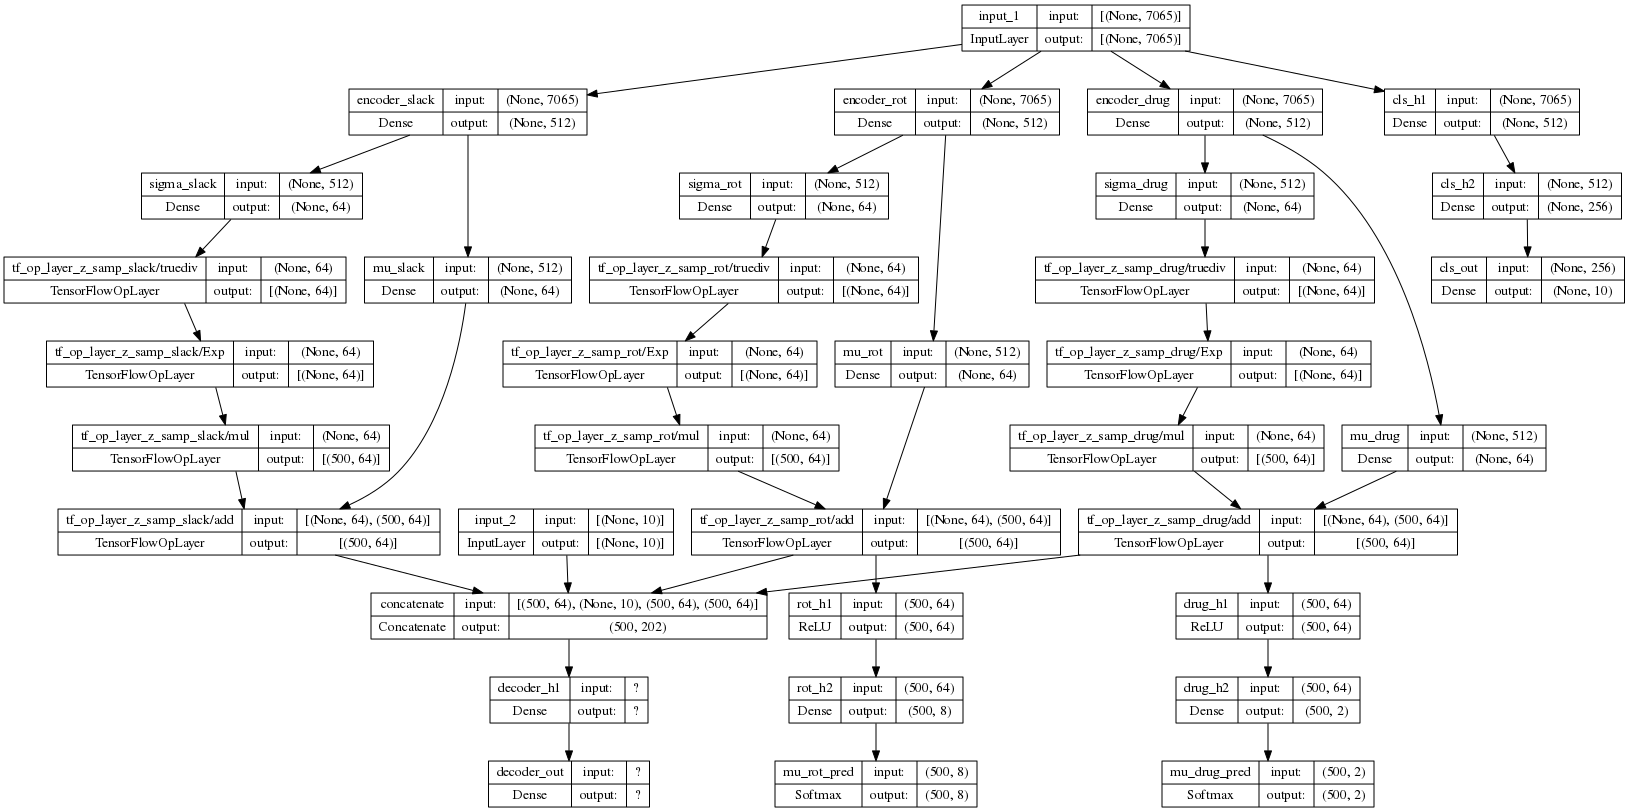

In [23]:
display(plot_model(known_prop_vae, show_layer_names=True, show_shapes=True, dpi=72))

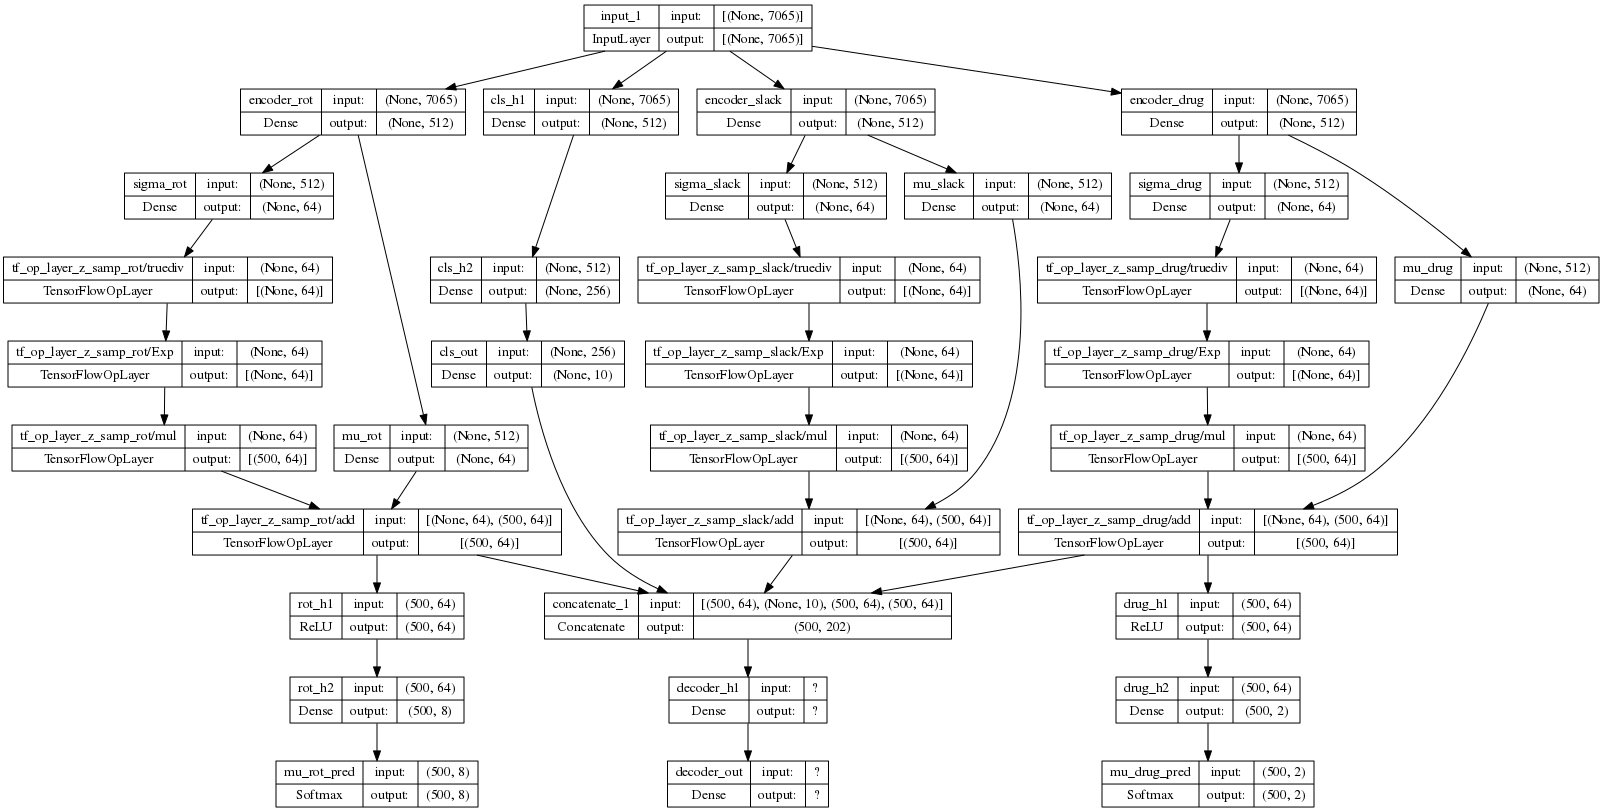

In [24]:
display(plot_model(unknown_prop_vae, show_layer_names=True, show_shapes=True, dpi=72))

# **Training**

Here we train using both the known and unknown cell-type proportions.
The labeled data is repeated in order to match the dimension of the unlabeled data so that they have the same batch size.
This code is taken from https://github.com/bjlkeng/sandbox/blob/master/notebooks/vae-semi_supervised_learning/vae-m2-fit-mnist.ipynb

In [25]:


def fit_model(X_unknown_prop, label_unknown_prop, drug_unknown_prop, X_known_prop, Y_known_prop, label_known_prop, drug_known_prop, epochs):
    assert len(X_unknown_prop) % len(X_known_prop) == 0, \
            (len(X_unknown_prop), batch_size, len(X_known_prop))
    start = time.time()
    history = []
    meta_hist = []
    
    for epoch in range(epochs):
        unlabeled_index = np.arange(len(X_unknown_prop))
        np.random.shuffle(unlabeled_index)

        # Repeat the unlabeled data to match length of labeled data
        labeled_index = []
        for i in range(len(X_unknown_prop) // len(X_known_prop)):
            l = np.arange(len(X_known_prop))
            np.random.shuffle(l)
            labeled_index.append(l)
        labeled_index = np.concatenate(labeled_index)
        
        batches = len(X_unknown_prop) // batch_size
        for i in range(batches):
            # Labeled
            index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
            loss = known_prop_vae.train_on_batch([X_known_prop[index_range], Y_known_prop[index_range]],
                                                    [X_known_prop[index_range], Y_known_prop[index_range], label_known_prop[index_range], drug_known_prop[index_range]])
            meta_hist.append(i)

            # Unlabeled
            index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
            loss += [unknown_prop_vae.train_on_batch(X_unknown_prop[index_range],
                                                        [X_unknown_prop[index_range], label_unknown_prop[index_range], drug_unknown_prop[index_range]])]

            meta_hist.append(i)

            history.append(loss)
            
    
   
    done = time.time()
    elapsed = done - start
    print("Elapsed: ", elapsed)
    
    return [history, meta_hist]

In [26]:
for layer in classifier.layers:
    print(layer)

In [27]:
for layer in encoder_unlab.layers:
    print(layer.name)

input_1
encoder_slack
encoder_rot
encoder_drug
sigma_slack
sigma_rot
sigma_drug
tf_op_layer_z_samp_slack/truediv
tf_op_layer_z_samp_rot/truediv
tf_op_layer_z_samp_drug/truediv
tf_op_layer_z_samp_slack/Exp
tf_op_layer_z_samp_rot/Exp
tf_op_layer_z_samp_drug/Exp
mu_slack
tf_op_layer_z_samp_slack/mul
mu_rot
tf_op_layer_z_samp_rot/mul
mu_drug
tf_op_layer_z_samp_drug/mul
tf_op_layer_z_samp_slack/add
tf_op_layer_z_samp_rot/add
tf_op_layer_z_samp_drug/add


Now train

In [28]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df


In [29]:
X_unkp.shape

(120, 7065)

In [30]:
x = np.array([[1,2],[3,4]])
x

array([[1, 2],
       [3, 4]])

In [31]:
X_kp.shape

(4000, 7065)

In [32]:
# X_unknown_prop, label_unknown_prop, X_known_prop, Y_known_prop, label_known_prop
loss_history = fit_model(np.repeat(X_unkp, 100, axis=0),
                    np.repeat(label_unkp, 100, axis=0),
                    np.repeat(drug_unkp, 100, axis=0),
                    X_kp, 
                    y_kp,
                    label_kp, 
                    drug_kp, epochs=n_epoch)



Elapsed:  1220.8085389137268


In [33]:
meta_history = loss_history[1]
loss_history = loss_history[0]

# Plot Loss Curves

In [34]:
# write out the loss for later plotting
# unpack the loss values
labeled_total_loss = [item[0] for item in loss_history]
unlabeled_total_loss = [item[5][0] for item in loss_history]

labeled_recon_loss = [item[1] for item in loss_history]
unlabeled_recon_loss = [item[5][1] for item in loss_history]

labeled_prop_loss = [item[2] for item in loss_history]

labeled_samp_loss = [item[3] for item in loss_history]
unlabeled_samp_loss = [item[5][2] for item in loss_history]

labeled_drug_loss = [item[4] for item in loss_history]
unlabeled_drug_loss = [item[5][2] for item in loss_history]


# make into a dataframe
total_loss = labeled_total_loss + unlabeled_total_loss + [a + b for a, b in zip(labeled_total_loss, unlabeled_total_loss)]
loss_df = pd.DataFrame(data=total_loss, columns=['total_loss'])
loss_df['type'] = ["labeled"]*len(loss_history) + ["unlabeled"]*len(loss_history) + ["sum"]*len(loss_history)
loss_df['batch'] = [*range(len(loss_history))] + [*range(len(loss_history))] + [*range(len(loss_history))]

recon_loss = labeled_recon_loss + unlabeled_recon_loss + [a + b for a, b in zip(labeled_recon_loss, unlabeled_recon_loss)]
loss_df['recon_loss'] = recon_loss

prop_loss = labeled_prop_loss + [0]*len(loss_history) + labeled_prop_loss
loss_df['prop_loss'] = prop_loss

samp_loss = labeled_samp_loss + unlabeled_samp_loss + [a + b for a, b in zip(labeled_samp_loss, unlabeled_samp_loss)]
loss_df['samp_loss'] = samp_loss


drug_loss = labeled_drug_loss + unlabeled_drug_loss + [a + b for a, b in zip(labeled_drug_loss, unlabeled_drug_loss)]
loss_df['drug_loss'] = drug_loss



In [35]:
loss_df

total_loss     type  batch     recon_loss    prop_loss     samp_loss  \
0     5.764079e+06  labeled      0    5277.393066  6645.738770  3.542155e+06   
1     1.928968e+06  labeled      1   83167.789062  6897.099121  1.838897e+06   
2     1.321465e+06  labeled      2  168563.281250  6420.459961  1.146481e+06   
3     7.526475e+05  labeled      3  217705.312500  6578.152344  5.283639e+05   
4     4.529884e+05  labeled      4  253163.890625  6779.530273  1.930448e+05   
...            ...      ...    ...            ...          ...           ...   
7195  1.414193e+04      sum   2395   11546.154297   336.735931  1.083159e+03   
7196  1.428598e+04      sum   2396   12588.982422   330.578461  8.648487e+02   
7197  1.391247e+04      sum   2397   12351.056641   315.130524  9.101211e+02   
7198  1.382923e+04      sum   2398   11418.378906   308.785400  9.796818e+02   
7199  1.383793e+04      sum   2399   11727.472656   315.800262  1.059991e+03   

         drug_loss  
0     2.210001e+06  
1     6.043248e+00  
2     1.517444e-01  
3     1.478309e-01  
4     1.478210e-01  
...            ...  
7195  1.262313e+03  
7196  6.755974e+02  
7197  6.785140e+02  
7198  7.149333e+02  
7199  7.344951e+02  

[7200 rows x 7 columns]

In [36]:
def read_loss_file(res_path, exp_id, unlab_id):
    loss_file = os.path.join(res_path, f"train-{exp_id}-{unlab_id}-DIVA_loss.pkl")
    loss_path = Path(loss_file)
    loss_df = pickle.load( open( loss_path, "rb" ) )
    return loss_df

def make_loss_fig(loss_df, ax, title, loss_to_plot):
    ## plot loss
    g = sns.lineplot(
        x="batch", y=loss_to_plot,
        data=loss_df,
        hue="type",
        legend="full",
        alpha=0.3, ax= ax
    )
    ax.set_title(title)
    return g

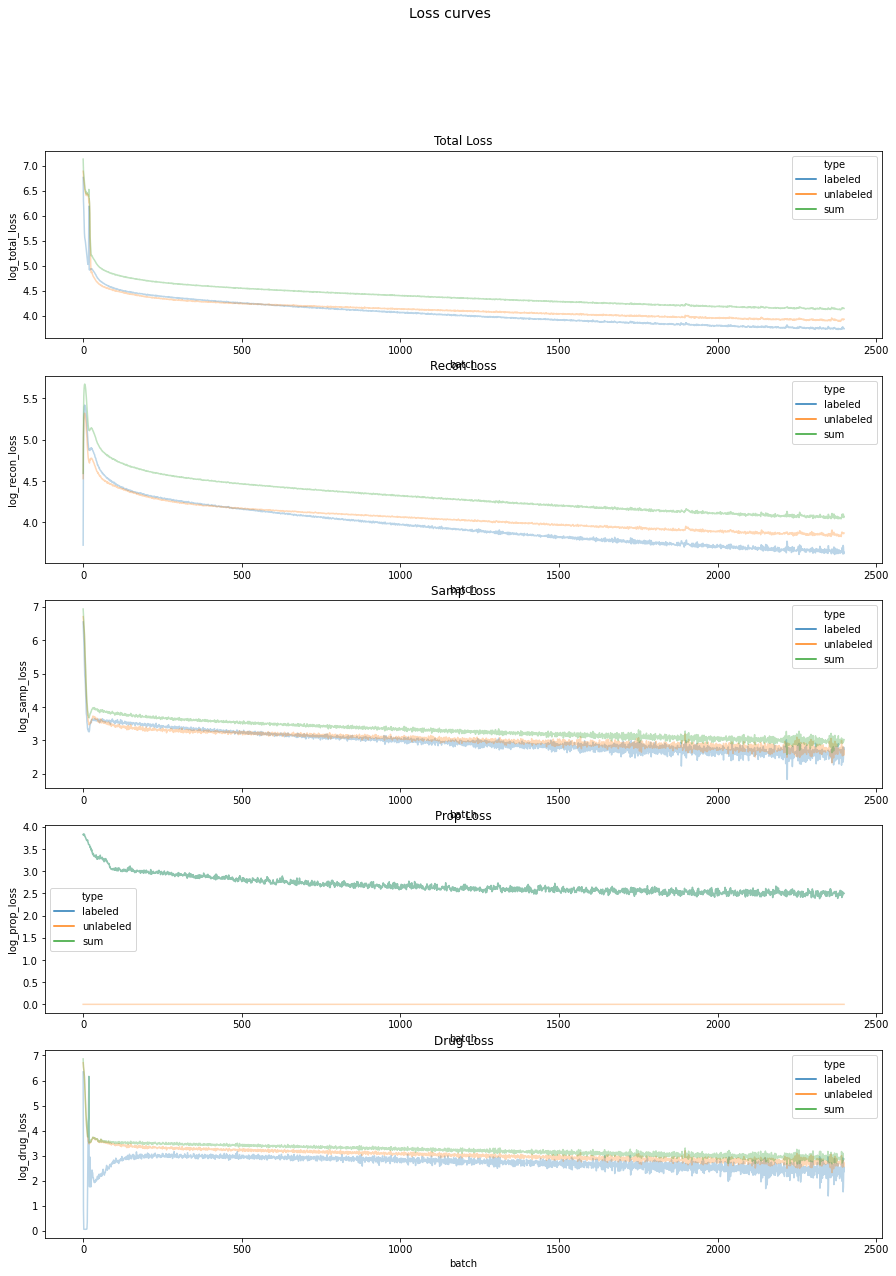

In [37]:

# add the log to make it easier to plot
loss_df["log_total_loss"] = np.log10(loss_df["total_loss"]+1)
loss_df["log_recon_loss"] = np.log10(loss_df["recon_loss"]+1)
loss_df["log_samp_loss"] = np.log10(loss_df["samp_loss"]+1)
loss_df["log_prop_loss"] = np.log10(loss_df["prop_loss"]+1)
loss_df["log_drug_loss"] = np.log10(loss_df["drug_loss"]+1)


fig, axs = plt.subplots(5, figsize=(15,20))

make_loss_fig(loss_df, ax=axs[0], title=f"Total Loss", loss_to_plot="log_total_loss")
make_loss_fig(loss_df, ax=axs[1], title=f"Recon Loss", loss_to_plot="log_recon_loss")
make_loss_fig(loss_df, ax=axs[2], title=f"Samp Loss", loss_to_plot="log_samp_loss")
make_loss_fig(loss_df, ax=axs[3], title=f"Prop Loss", loss_to_plot="log_prop_loss")
make_loss_fig(loss_df, ax=axs[4], title=f"Drug Loss", loss_to_plot="log_drug_loss")


fig.suptitle("Loss curves", fontsize=14)

fig.show()

In [38]:
def plot_cell_specific_corr(xval, yval, ax, title, xlab, ylab, class_id):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax,
        hue=class_id
    )
    g.set(ylim=(0, 1))
    g.set(xlim=(0, 1))
    g.plot([0, 1], [0, 1], transform=g.transAxes)

    ax.set_title(title)
    return g


def read_bp_result_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df

def read_bp_init_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


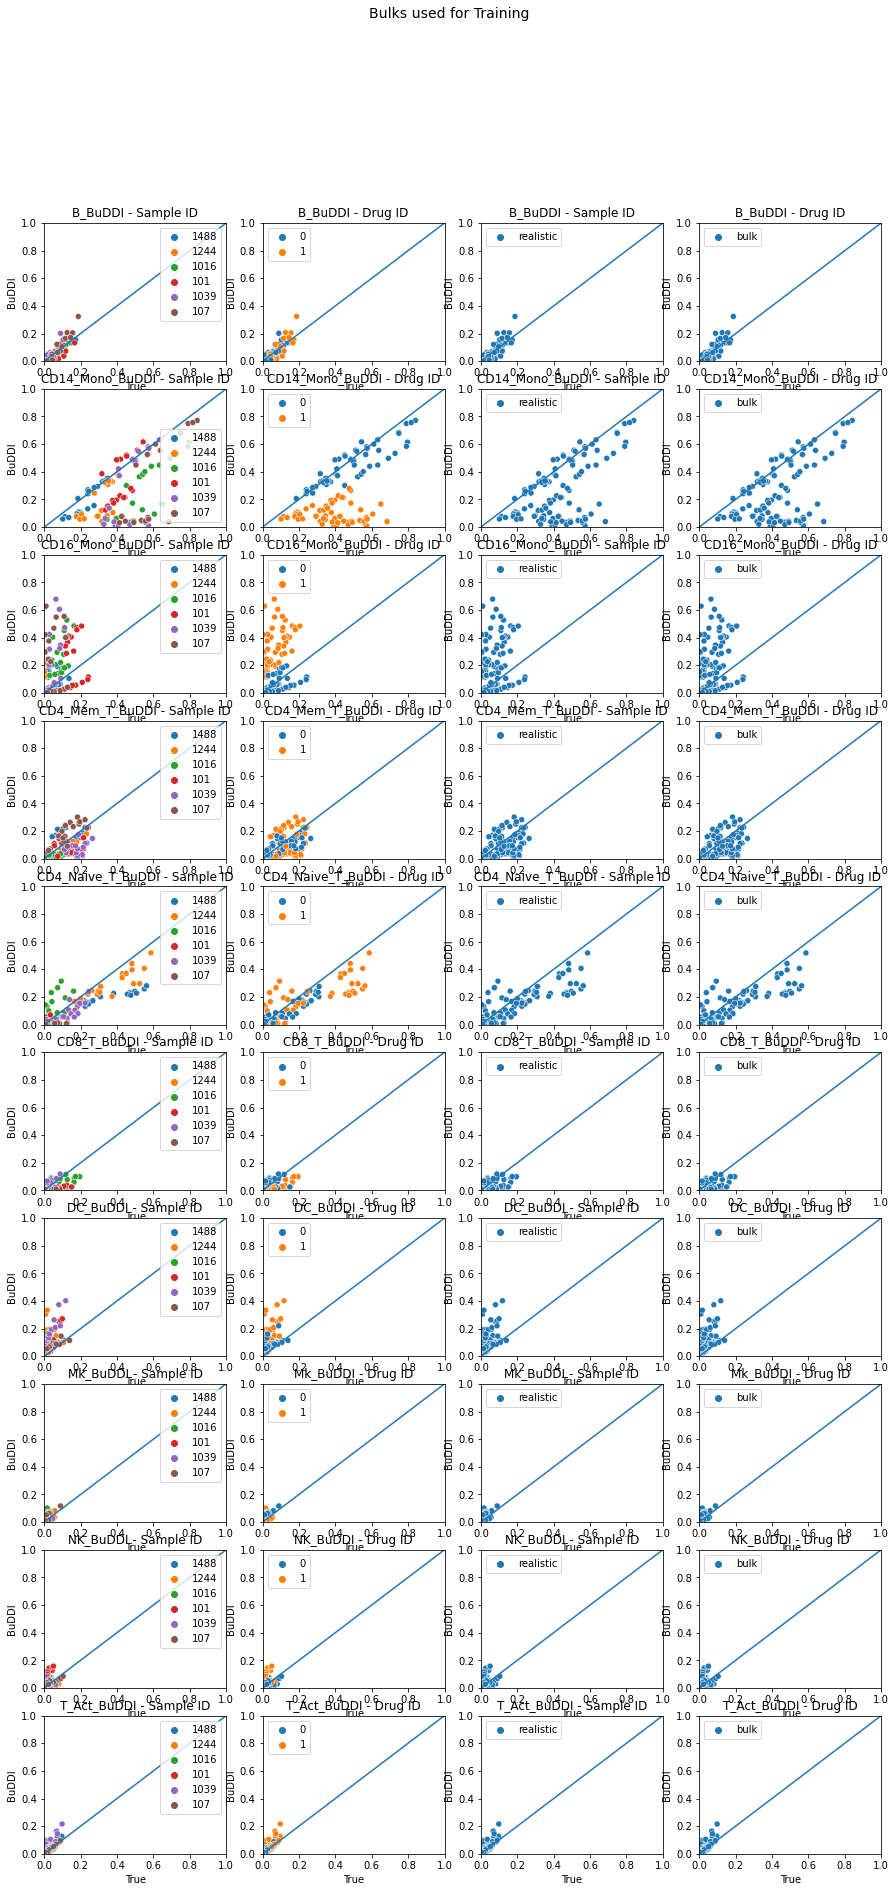

In [39]:
idx_tmp = np.intersect1d(idx_bulk, idx_train)
X_tmp = X_full[idx_tmp,]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

## plot for the unlabeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_full.columns)
true_prop_df = Y_full.iloc[idx_tmp]

label_temp = np.copy(Label_full)
label_temp = index_label[label_temp]



fig, axs = plt.subplots(10, 4, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=label_temp[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,2], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=meta_df.cell_prop_type.to_numpy()[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,3], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=meta_df.samp_type.to_numpy()[idx_tmp])
        
    row_idx = row_idx +1


fig.suptitle("Bulks used for Training", fontsize=14)

fig.show()

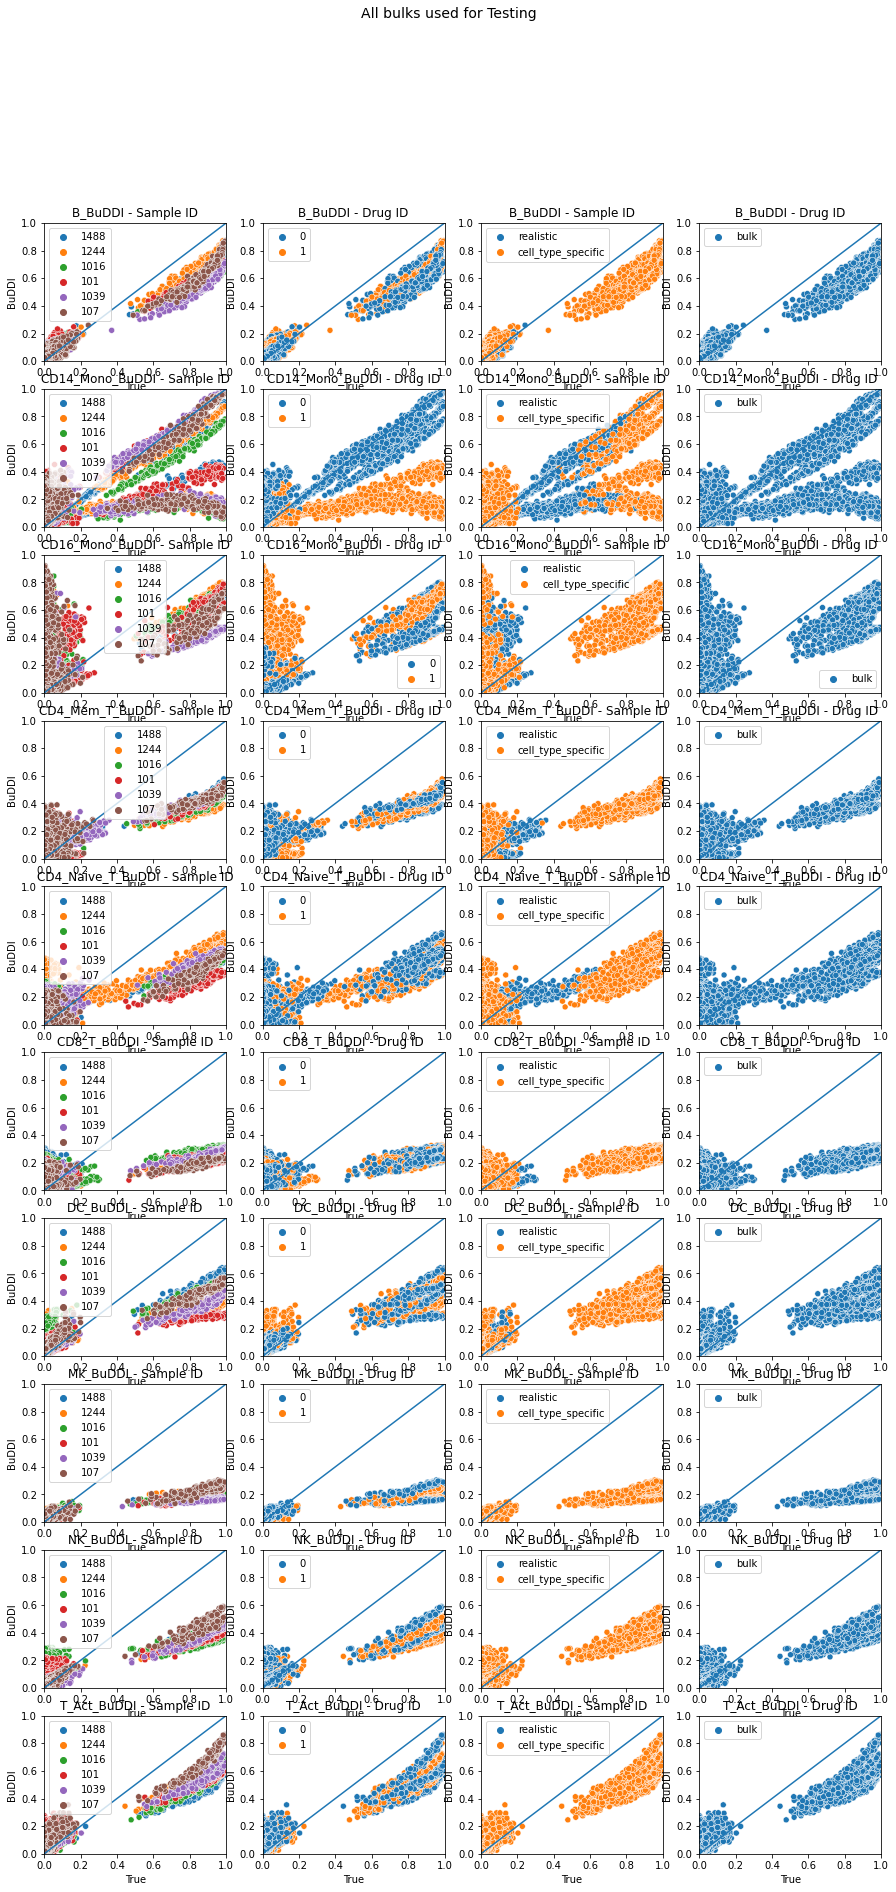

In [40]:
idx_tmp = idx_test
X_tmp = X_full[idx_tmp,]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

## plot for the unlabeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_full.columns)
true_prop_df = Y_full.iloc[idx_tmp]

label_temp = np.copy(Label_full)
label_temp = index_label[label_temp]



fig, axs = plt.subplots(10, 4, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=label_temp[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,2], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=meta_df.cell_prop_type.to_numpy()[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,3], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=meta_df.samp_type.to_numpy()[idx_tmp])
    row_idx = row_idx +1


fig.suptitle("All bulks used for Testing", fontsize=14)

fig.show()

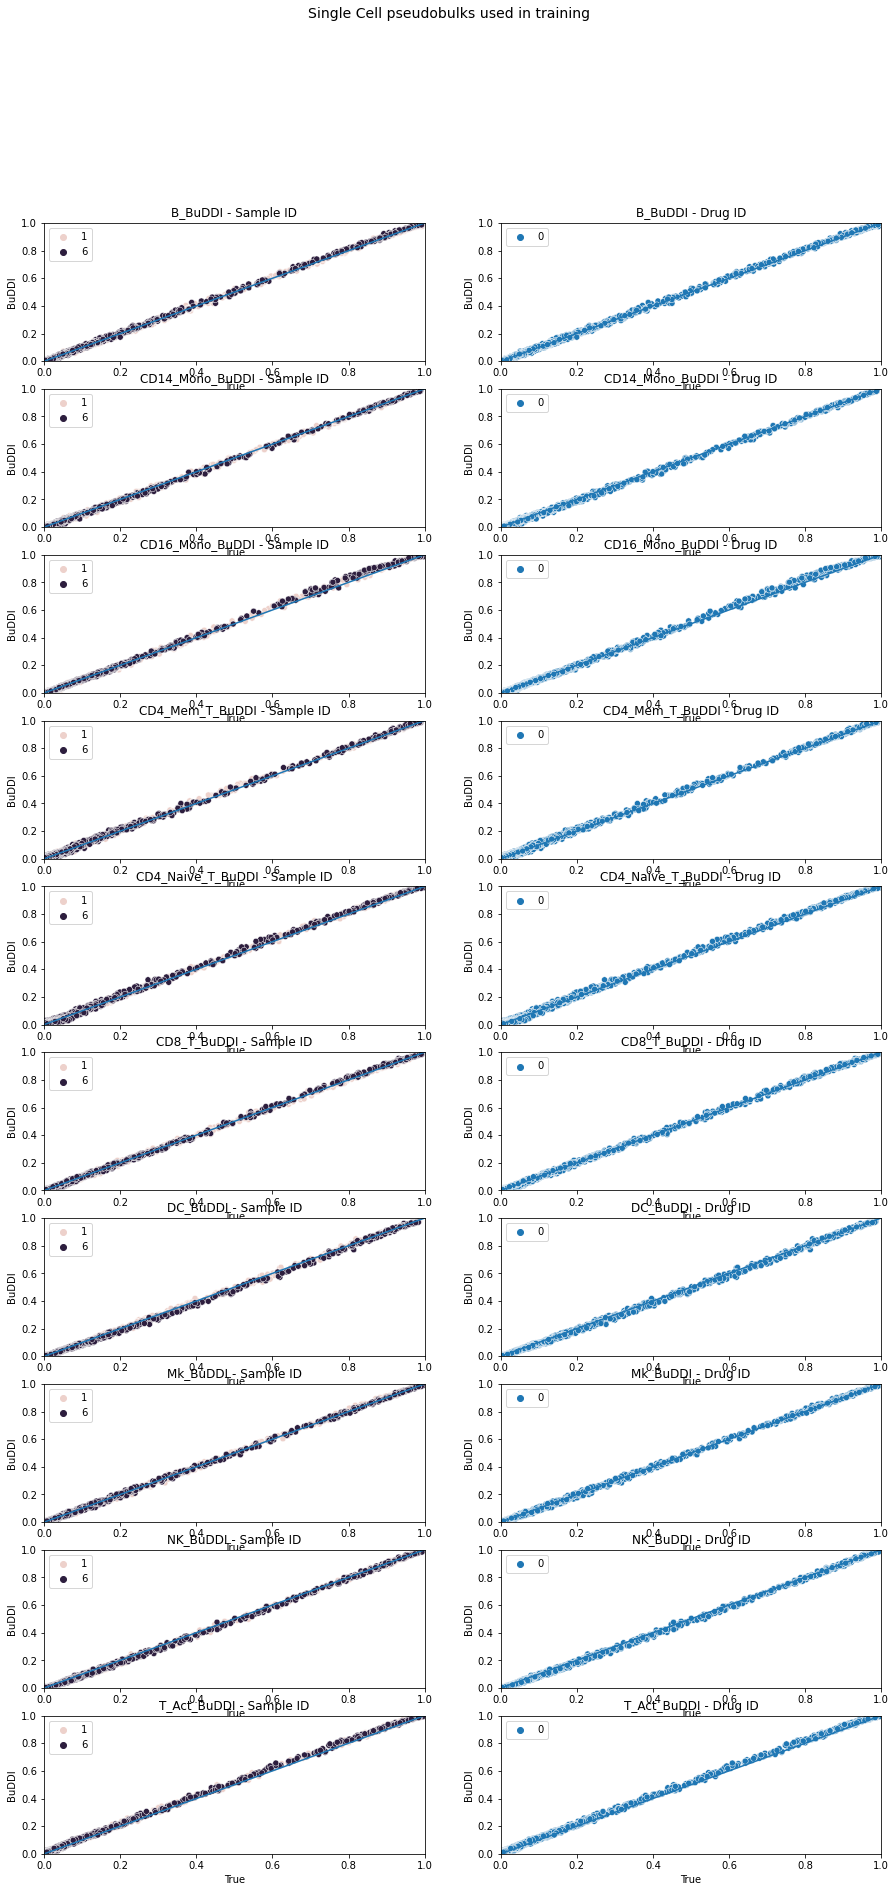

In [41]:
idx_tmp = idx_sc
X_tmp = X_full[idx_tmp,]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

## plot for the unlabeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_full.columns)
true_prop_df = Y_full.iloc[idx_tmp]

fig, axs = plt.subplots(10, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=Label_full[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_tmp])
    row_idx = row_idx +1


fig.suptitle("Single Cell pseudobulks used in training", fontsize=14)

fig.show()

### compare errors

In [42]:
def read_diva_result_file(res_path, train_id, test_id, unlab_id):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-DIVA.pkl")
    res_path = Path(res_file)
    res_df = pickle.load( open( res_path, "rb" ) )
    return res_df

def read_bp_result_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df

def read_bp_init_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df




In [43]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df


def get_errors_single(y_true, y_est):
  mse_err = [mean_sqr_error(y_true, y_est)]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true, y_est)[0]]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true, y_est)[0]]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"] + ["SPR"] + ["PEAR"]

  return plot_df




In [44]:
meta_df

sample_id  stim isTraining      cell_prop_type samp_type  Y_max
0         1015  CTRL      Train              random    sc_ref  T_Act
1         1015  CTRL      Train              random    sc_ref      B
2         1015  CTRL      Train              random    sc_ref     DC
3         1015  CTRL      Train              random    sc_ref     DC
4         1015  CTRL      Train              random    sc_ref      B
...        ...   ...        ...                 ...       ...    ...
1095       107  CTRL       Test  cell_type_specific      bulk     NK
1096       107  CTRL       Test  cell_type_specific      bulk     NK
1097       107  CTRL       Test  cell_type_specific      bulk     NK
1098       107  CTRL       Test  cell_type_specific      bulk     NK
1099       107  CTRL       Test  cell_type_specific      bulk     NK

[17320 rows x 6 columns]

MSqE mean: 0.002136557929463672, median: 0.0016900090089145784, max: 0.005711144248370269
Spearman mean: 0.7236363636363635, median: 0.7333333333333332, max: 0.9515151515151514
Pearson mean: 0.9534060254375375, median: 0.9606070852650901, max: 0.9948244930392515
MSqE mean: 0.02300592860369473, median: 0.016214619618494824, max: 0.08019630875678621
Spearman mean: 0.42767676767676766, median: 0.47272727272727266, max: 0.8424242424242423
Pearson mean: 0.33797896966187563, median: 0.3013108396874281, max: 0.8962165666558236


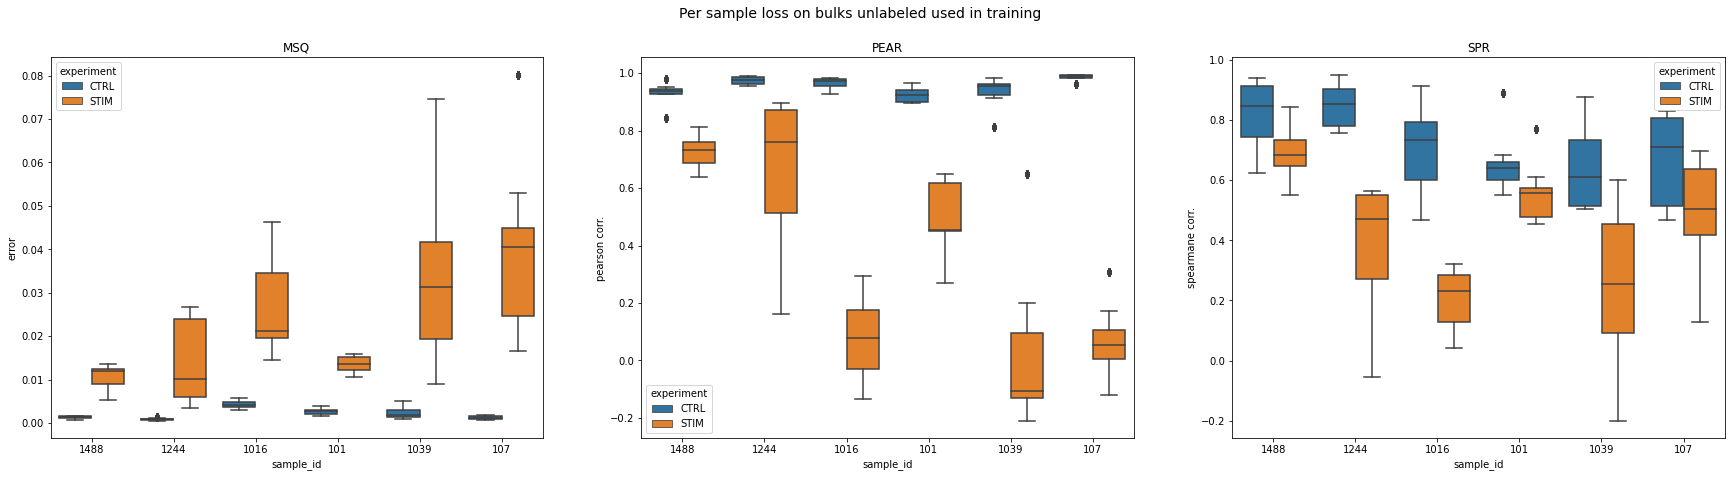

In [45]:
# Now compare across samples
idx_tmp = np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "CTRL")
idx_tmp = np.where( idx_tmp)[0]
idx_tmp = np.tile(idx_tmp, 100)


X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err_ctrl = get_errors(Y_tmp.to_numpy(), prop_outputs)


# format the errors
buddi_err_ctrl["experiment"] = ["CTRL"]*buddi_err_ctrl.shape[0]
buddi_err_ctrl["method"] = ["BuDDI"]*buddi_err_ctrl.shape[0]
buddi_err_ctrl["sample_id"] = np.tile(samp_ids, 3)


# Now compare across samples
idx_tmp = np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "STIM")
idx_tmp = np.where( idx_tmp)[0]
idx_tmp = np.tile(idx_tmp, 100)


X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err_stim = get_errors(Y_tmp.to_numpy(), prop_outputs)


# format the errors
buddi_err_stim["experiment"] = ["STIM"]*buddi_err_stim.shape[0]
buddi_err_stim["method"] = ["BuDDI"]*buddi_err_stim.shape[0]
buddi_err_stim["sample_id"] = np.tile(samp_ids, 3)

plot_df = pd.concat([buddi_err_ctrl, buddi_err_stim])



# plot
fig, axs = plt.subplots(1, 3, figsize=(30,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")


sns.boxplot(data=plot_df[plot_df["error_type"] == "SPR"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[2])
axs[2].set_title("SPR")
axs[2].set(ylabel="spearmane corr.")
fig.suptitle("Per sample loss on bulks unlabeled used in training", fontsize=14)

fig.show()

MSqE mean: 0.0018754986069145362, median: 0.0012611239023226357, max: 0.009635030964149137
Spearman mean: 0.7492727272727273, median: 0.7939393939393938, max: 0.9999999999999999
Pearson mean: 0.9656132568740422, median: 0.970823530669198, max: 0.9996723477828451
MSqE mean: 0.021964425695161736, median: 0.01625641988810933, max: 0.12664052231894435
Spearman mean: 0.48436363636363633, median: 0.5030303030303029, max: 0.9272727272727272
Pearson mean: 0.43524015387844817, median: 0.4502076624637771, max: 0.9246718104517292


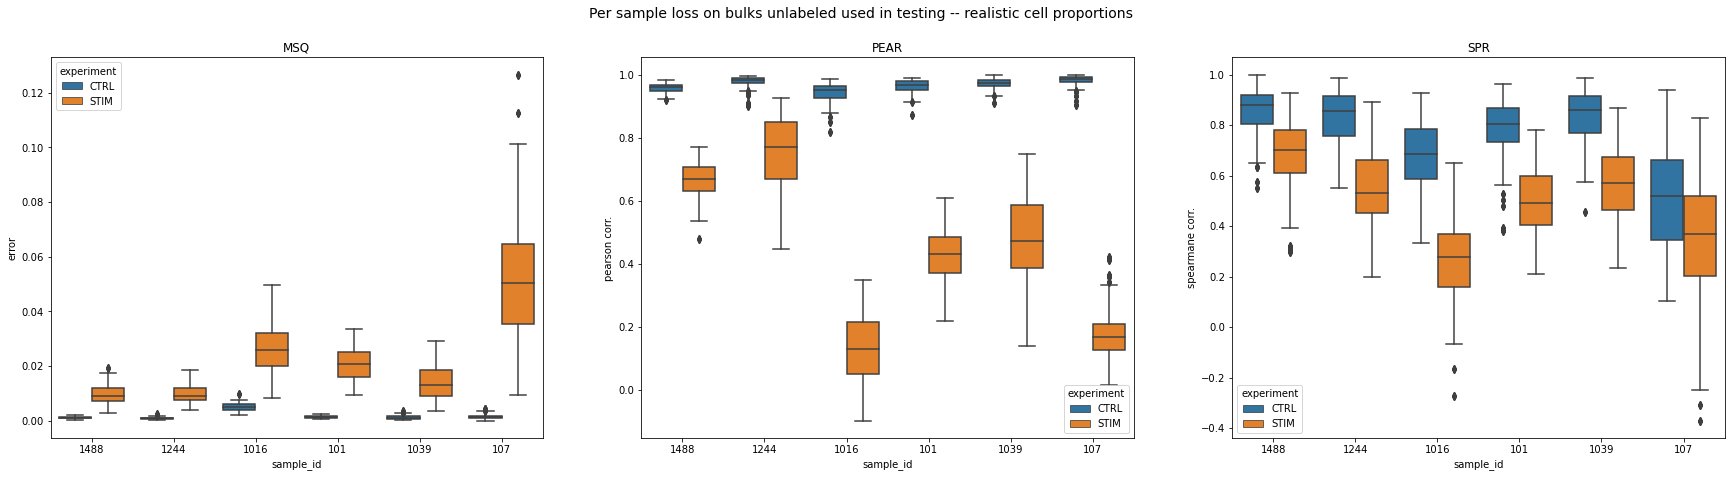

In [46]:
# Now compare across samples
idx_tmp = np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Test")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "CTRL")
idx_tmp = np.logical_and(idx_tmp, meta_df.cell_prop_type == "realistic")
idx_tmp = np.where( idx_tmp)[0]
idx_tmp = np.tile(idx_tmp, 5)


X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err_ctrl = get_errors(Y_tmp.to_numpy(), prop_outputs)


# format the errors
buddi_err_ctrl["experiment"] = ["CTRL"]*buddi_err_ctrl.shape[0]
buddi_err_ctrl["method"] = ["BuDDI"]*buddi_err_ctrl.shape[0]
buddi_err_ctrl["sample_id"] = np.tile(samp_ids, 3)


# Now compare across samples
idx_tmp = np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Test")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "STIM")
idx_tmp = np.logical_and(idx_tmp, meta_df.cell_prop_type == "realistic")
idx_tmp = np.where( idx_tmp)[0]
idx_tmp = np.tile(idx_tmp, 5)


X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err_stim = get_errors(Y_tmp.to_numpy(), prop_outputs)


# format the errors
buddi_err_stim["experiment"] = ["STIM"]*buddi_err_stim.shape[0]
buddi_err_stim["method"] = ["BuDDI"]*buddi_err_stim.shape[0]
buddi_err_stim["sample_id"] = np.tile(samp_ids, 3)

plot_df = pd.concat([buddi_err_ctrl, buddi_err_stim])



# plot
fig, axs = plt.subplots(1, 3, figsize=(30,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")


sns.boxplot(data=plot_df[plot_df["error_type"] == "SPR"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[2])
axs[2].set_title("SPR")
axs[2].set(ylabel="spearmane corr.")
fig.suptitle("Per sample loss on bulks unlabeled used in testing -- realistic cell proportions", fontsize=14)

fig.show()

MSqE mean: 0.025715737665279684, median: 0.02237966660056813, max: 0.08644047613428255
Spearman mean: 0.4104767676767676, median: 0.43030303030303024, max: 0.9878787878787878
Pearson mean: 0.8028422341144146, median: 0.8846553429260806, max: 0.9999808294174641
MSqE mean: 0.03294067278762684, median: 0.02671630107329779, max: 0.16707490791142898
Spearman mean: 0.3933292929292928, median: 0.41818181818181815, max: 0.9757575757575757
Pearson mean: 0.7417414409088262, median: 0.8737240036536719, max: 0.9994092859904934


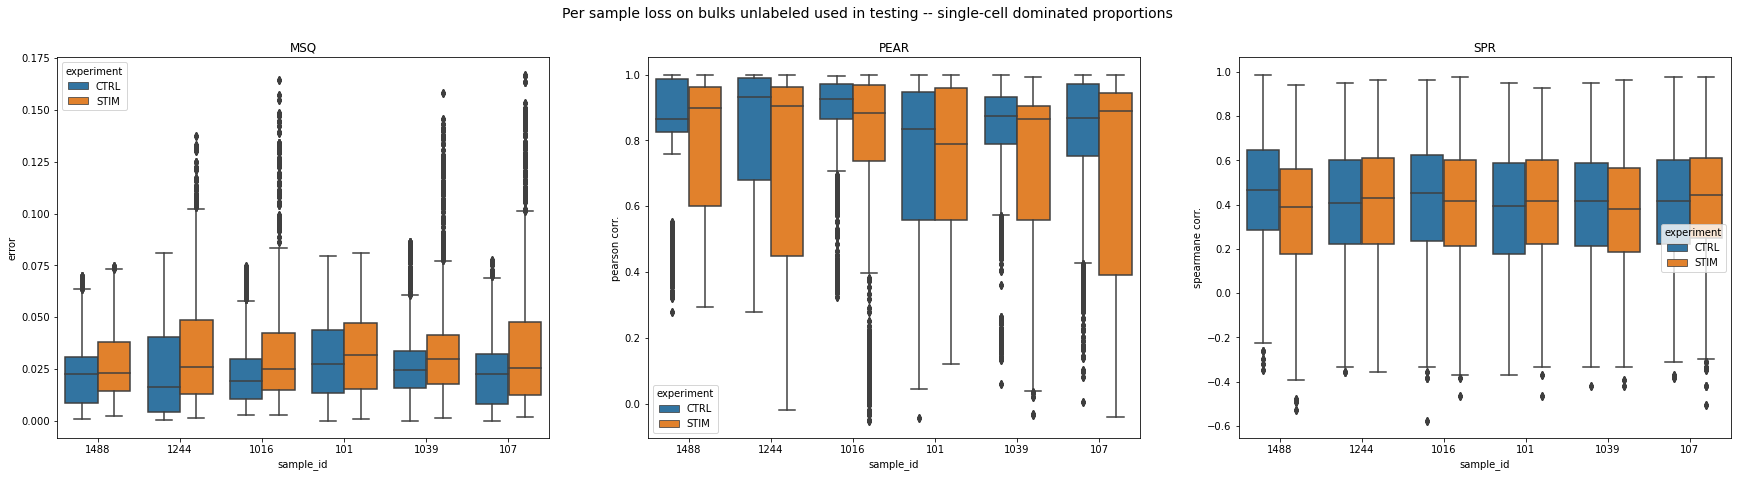

In [47]:
# Now compare across samples
idx_tmp = np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Test")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "CTRL")
idx_tmp = np.logical_and(idx_tmp, meta_df.cell_prop_type == "cell_type_specific")
idx_tmp = np.where( idx_tmp)[0]
idx_tmp = np.tile(idx_tmp, 5)


X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err_ctrl = get_errors(Y_tmp.to_numpy(), prop_outputs)


# format the errors
buddi_err_ctrl["experiment"] = ["CTRL"]*buddi_err_ctrl.shape[0]
buddi_err_ctrl["method"] = ["BuDDI"]*buddi_err_ctrl.shape[0]
buddi_err_ctrl["sample_id"] = np.tile(samp_ids, 3)


# Now compare across samples
idx_tmp = np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Test")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "STIM")
idx_tmp = np.logical_and(idx_tmp, meta_df.cell_prop_type == "cell_type_specific")
idx_tmp = np.where( idx_tmp)[0]
idx_tmp = np.tile(idx_tmp, 5)


X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err_stim = get_errors(Y_tmp.to_numpy(), prop_outputs)


# format the errors
buddi_err_stim["experiment"] = ["STIM"]*buddi_err_stim.shape[0]
buddi_err_stim["method"] = ["BuDDI"]*buddi_err_stim.shape[0]
buddi_err_stim["sample_id"] = np.tile(samp_ids, 3)

plot_df = pd.concat([buddi_err_ctrl, buddi_err_stim])



# plot
fig, axs = plt.subplots(1, 3, figsize=(30,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")


sns.boxplot(data=plot_df[plot_df["error_type"] == "SPR"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[2])
axs[2].set_title("SPR")
axs[2].set(ylabel="spearmane corr.")
fig.suptitle("Per sample loss on bulks unlabeled used in testing -- single-cell dominated proportions", fontsize=14)

fig.show()

# **Inspect the output**

## TSNE training data

Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

## Plot Reconstruction

In [48]:
recon_idx = np.logical_and(meta_df.cell_prop_type == "realistic", meta_df.isTraining == "Test")
recon_idx = np.where(recon_idx)[0]




Y_temp = np.copy(Y_full.iloc[recon_idx])
Y_temp = np.argmax(Y_temp, axis=1)


label_temp = np.copy(Label_full[recon_idx])
perturb_temp = Drug_full[recon_idx]

# need duplicates
len_recon_idx = len(recon_idx)
recon_idx = np.tile(recon_idx, 5)
X_temp = np.copy(X_full[recon_idx])


prop_outputs = classifier.predict(X_temp, batch_size=batch_size)



# now use the encoder to get the latent spaces
z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)

# now concatenate together
z_concat = np.hstack([z_slack, prop_outputs, z_rot, z_drug])

# and decode
decoded_outputs = decoder.predict(z_concat, batch_size=batch_size)

decoded_outputs = decoded_outputs[0:len_recon_idx]
X_temp = X_temp[0:len_recon_idx]


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(1200, 2)
(1200, 2)


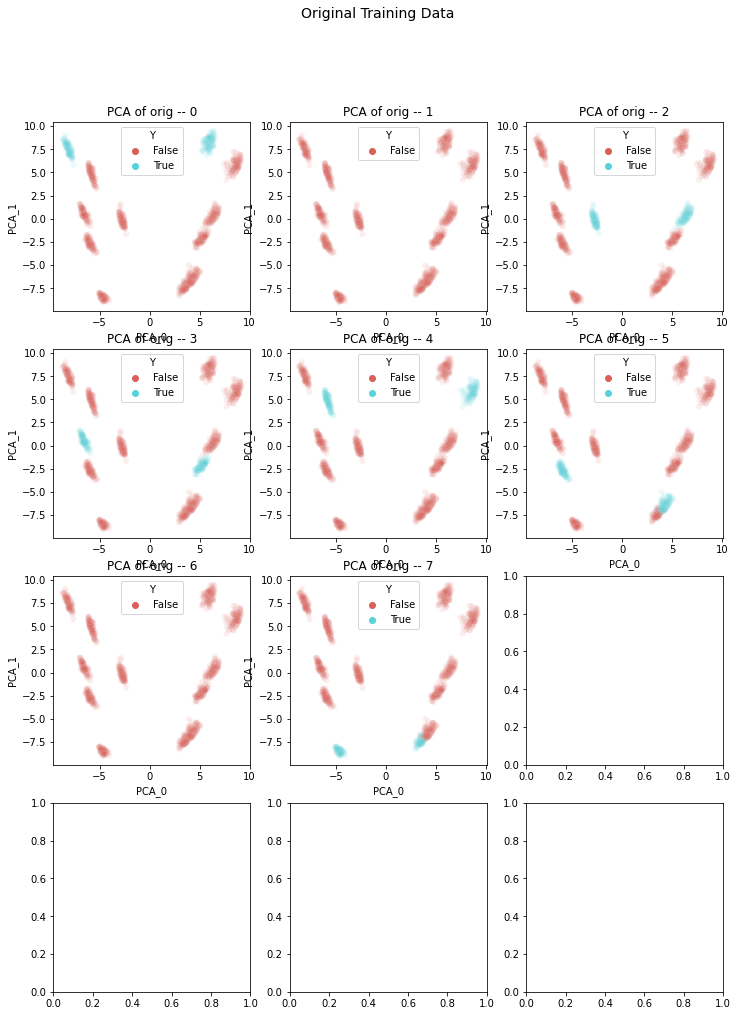

In [49]:

fig, axs = plt.subplots(4, 3, figsize=(12,16))

plot_df = vp.get_pca_for_plotting(np.asarray(X_temp))
vp.plot_pca(plot_df, color_vec=label_temp==0, ax=axs[0,0], title="PCA of orig -- 0")
vp.plot_pca(plot_df, color_vec=label_temp==1, ax=axs[0,1], title="PCA of orig -- 1")
vp.plot_pca(plot_df, color_vec=label_temp==2, ax=axs[0,2], title="PCA of orig -- 2")
vp.plot_pca(plot_df, color_vec=label_temp==3, ax=axs[1,0], title="PCA of orig -- 3")
vp.plot_pca(plot_df, color_vec=label_temp==4, ax=axs[1,1], title="PCA of orig -- 4")
vp.plot_pca(plot_df, color_vec=label_temp==5, ax=axs[1,2], title="PCA of orig -- 5")
vp.plot_pca(plot_df, color_vec=label_temp==6, ax=axs[2,0], title="PCA of orig -- 6")
vp.plot_pca(plot_df, color_vec=label_temp==7, ax=axs[2,1], title="PCA of orig -- 7")


fig.suptitle("Original Training Data", fontsize=14)

fig.show()

(1200, 2)
(1200, 2)


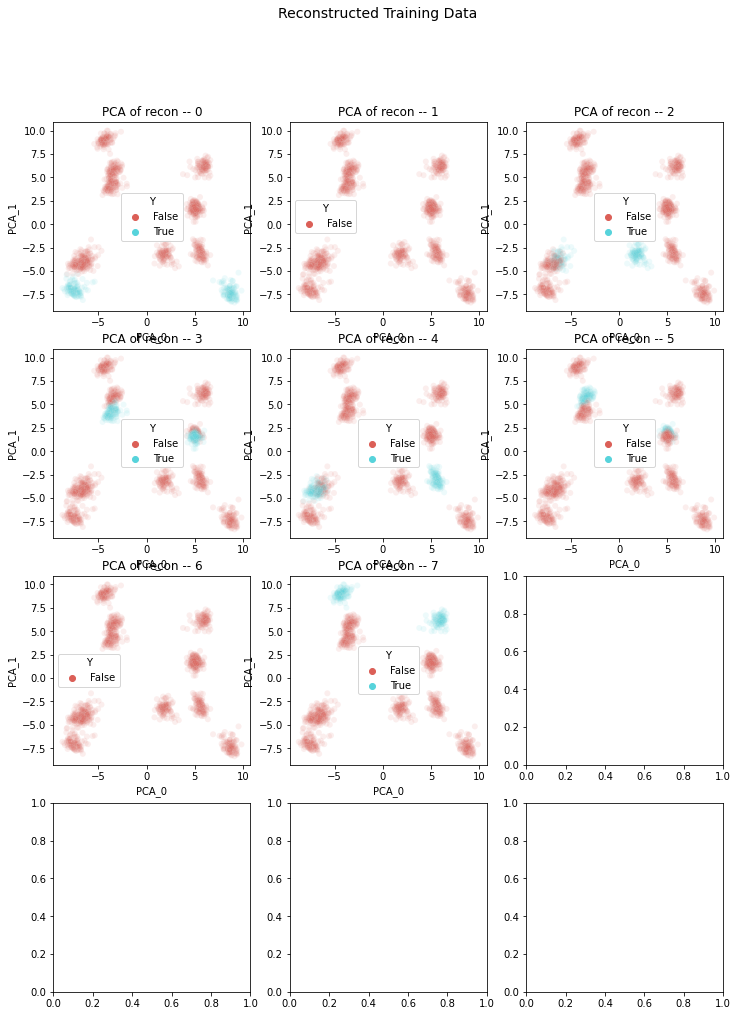

In [50]:

fig, axs = plt.subplots(4, 3, figsize=(12,16))

plot_df = vp.get_pca_for_plotting(np.asarray(decoded_outputs))
vp.plot_pca(plot_df, color_vec=label_temp==0, ax=axs[0,0], title="PCA of recon -- 0")
vp.plot_pca(plot_df, color_vec=label_temp==1, ax=axs[0,1], title="PCA of recon -- 1")
vp.plot_pca(plot_df, color_vec=label_temp==2, ax=axs[0,2], title="PCA of recon -- 2")
vp.plot_pca(plot_df, color_vec=label_temp==3, ax=axs[1,0], title="PCA of recon -- 3")
vp.plot_pca(plot_df, color_vec=label_temp==4, ax=axs[1,1], title="PCA of recon -- 4")
vp.plot_pca(plot_df, color_vec=label_temp==5, ax=axs[1,2], title="PCA of recon -- 5")
vp.plot_pca(plot_df, color_vec=label_temp==6, ax=axs[2,0], title="PCA of recon -- 6")
vp.plot_pca(plot_df, color_vec=label_temp==7, ax=axs[2,1], title="PCA of recon -- 7")


fig.suptitle("Reconstructed Training Data", fontsize=14)

fig.show()

In [51]:
X_temp

array([[0.        , 0.00462963, 0.        , ..., 0.38423846, 0.21437321,
        0.        ],
       [0.        , 0.00694444, 0.        , ..., 0.30093916, 0.17313189,
        0.        ],
       [0.        , 0.00771605, 0.        , ..., 0.31196407, 0.16006533,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.55124541, 0.02939976,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.44671294, 0.0204165 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.62270314, 0.02572479,
        0.        ]])

In [52]:
decoded_outputs

array([[1.17887137e-03, 2.11908855e-03, 3.50123667e-03, ...,
        4.26812321e-01, 2.51039714e-01, 7.74769578e-03],
       [8.07568664e-04, 2.71163438e-03, 6.34671142e-03, ...,
        3.84738445e-01, 2.55001277e-01, 1.23458765e-02],
       [5.43141854e-04, 1.16303901e-03, 1.99464709e-03, ...,
        3.70172471e-01, 2.65929878e-01, 4.41176072e-03],
       ...,
       [3.44944466e-03, 3.79824899e-02, 5.38305100e-03, ...,
        5.02128720e-01, 1.53643675e-02, 2.19344795e-02],
       [6.39829261e-04, 9.70492661e-02, 1.33060187e-03, ...,
        5.51556826e-01, 8.30798037e-03, 5.96142793e-03],
       [4.65137244e-04, 4.02371660e-02, 1.47968496e-03, ...,
        5.41435480e-01, 1.16667589e-02, 1.79180577e-02]], dtype=float32)

(2400, 2)
(2400, 2)


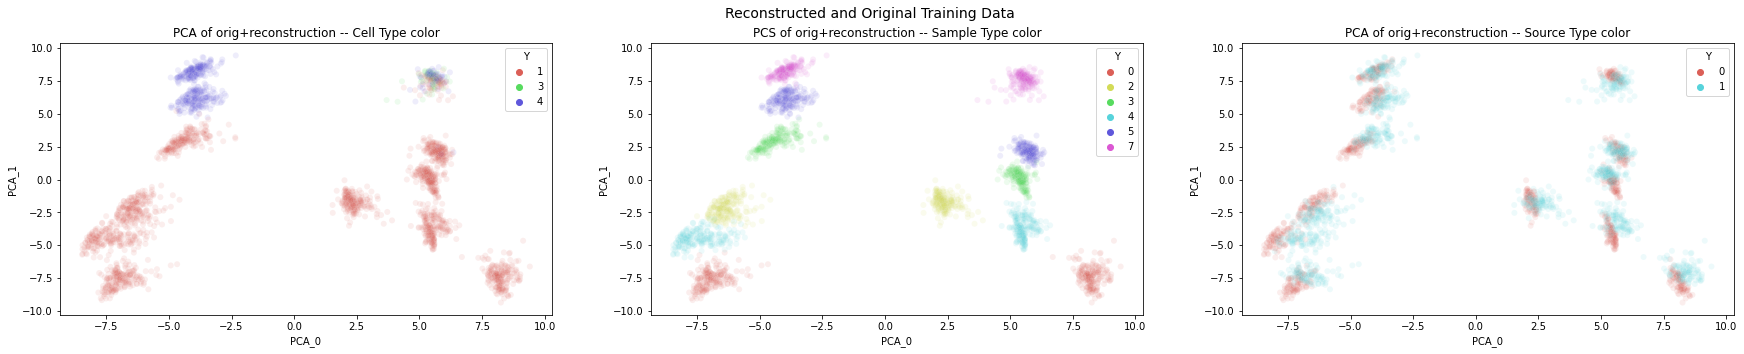

In [53]:
# make duplicated
X_dup = np.vstack([X_temp, decoded_outputs])


Y_dup = np.append(Y_temp, Y_temp)

label_dup = np.append(label_temp, label_temp)
perturb_dup = np.append(perturb_temp, perturb_temp)
source_dup = np.asarray(np.append([0]*1200, [1]*1200))

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = vp.get_pca_for_plotting(np.asarray(X_dup))
vp.plot_pca(plot_df, color_vec=Y_dup, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_dup, ax=axs[1], title="PCS of orig+reconstruction -- Sample Type color")
vp.plot_pca(plot_df, color_vec=source_dup, ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")


fig.suptitle("Reconstructed and Original Training Data", fontsize=14)

fig.show()

### Plot latent spaces

In [54]:
len(idx_train)

4120

Number unique Y: 10
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)


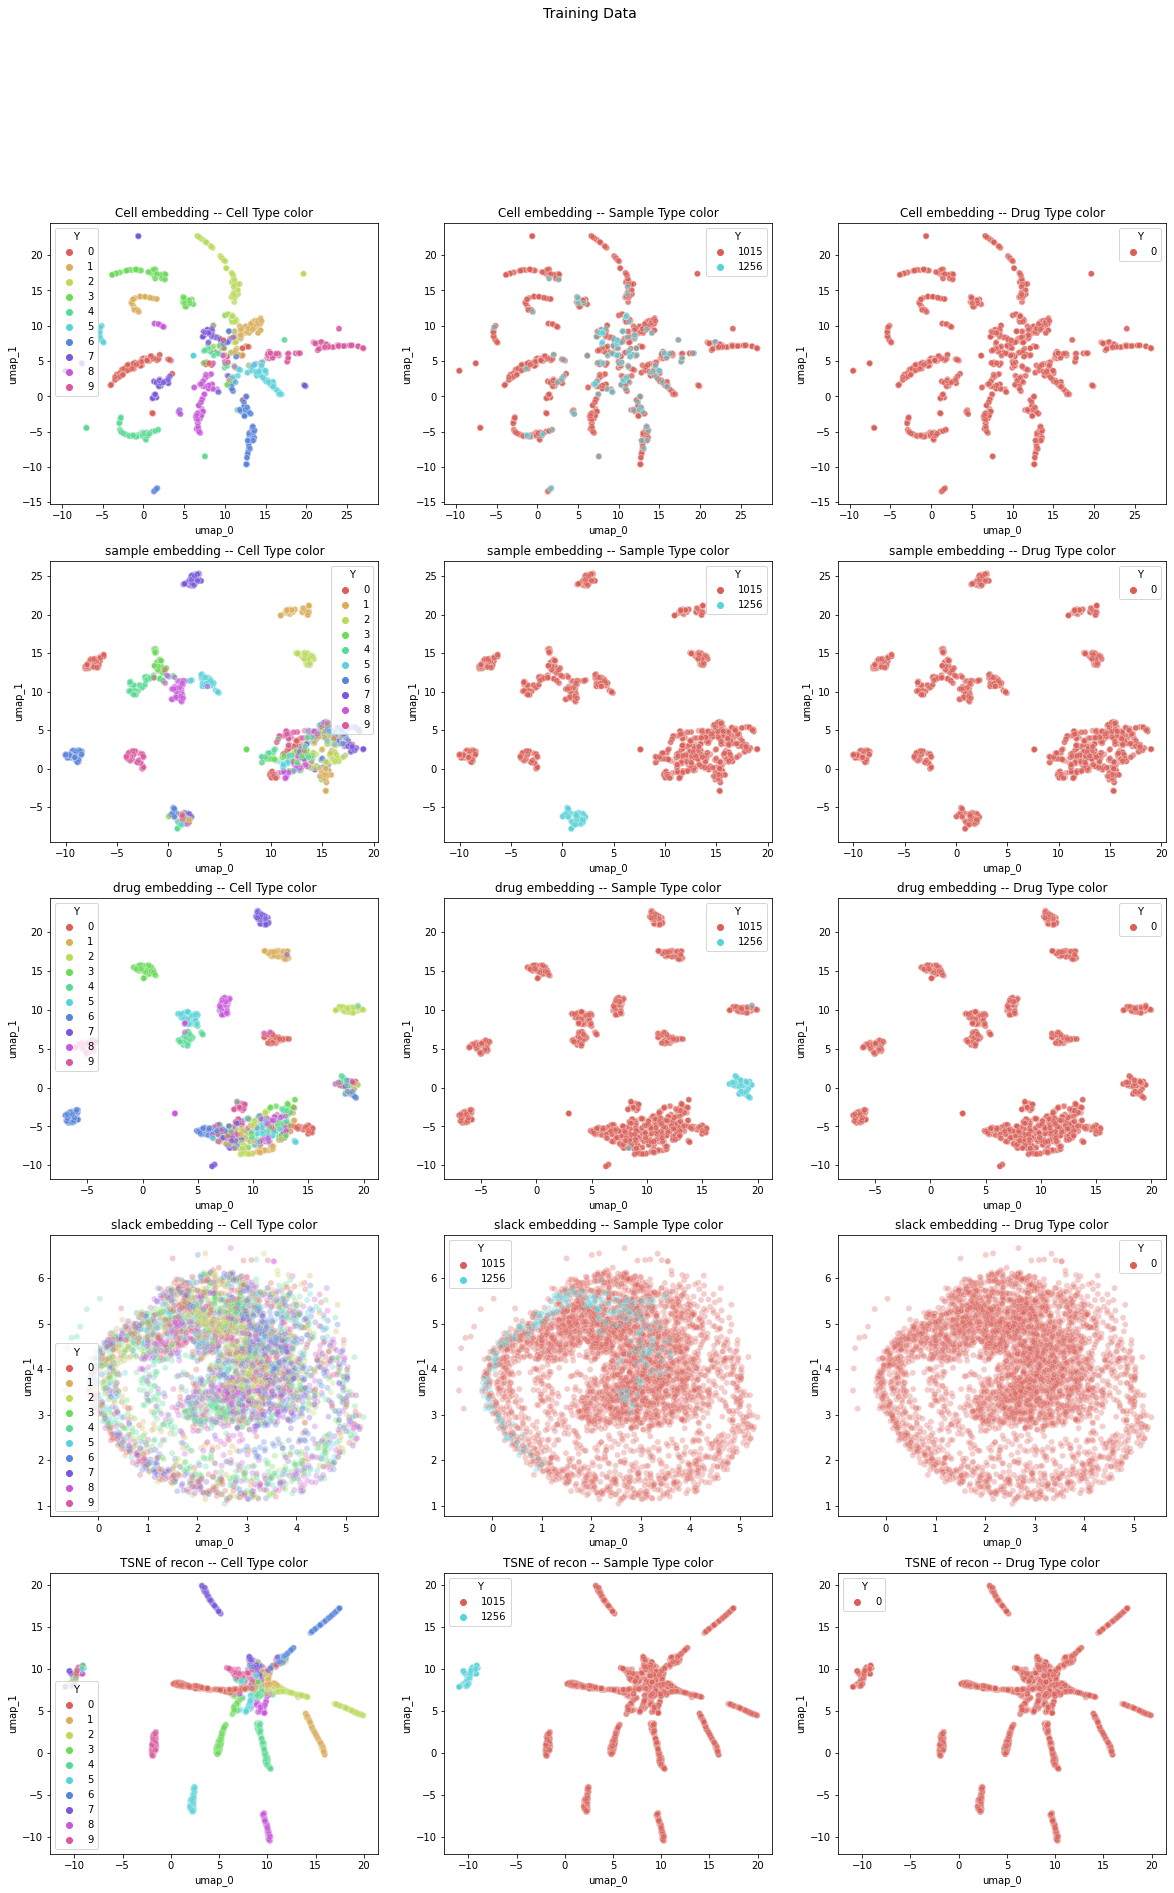

In [55]:
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data

idx_tmp = np.repeat(idx_train, 2)[240:4240]

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]

print(f"Number unique Y: {len(np.unique(Y_temp))}")


z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)
prop_outputs = classifier.predict(X_temp, batch_size=batch_size)


# now concatenate together
z_concat = np.hstack([z_slack, prop_outputs, z_rot, z_drug])

# and decode
decoded_outputs = decoder.predict(z_concat, batch_size=batch_size)


fig, axs = plt.subplots(5, 3, figsize=(20,30))

plot_df = vp.get_umap_for_plotting(np.asarray(prop_outputs))
vp.plot_umap(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
vp.plot_umap(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")
vp.plot_umap(plot_df, color_vec=perturb_temp, ax=axs[0,2], title="Cell embedding -- Drug Type color")

plot_df = vp.get_umap_for_plotting(np.asarray(mu_rot))
vp.plot_umap(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
vp.plot_umap(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")
vp.plot_umap(plot_df, color_vec=perturb_temp, ax=axs[1,2], title="sample embedding -- Drug Type color")

plot_df = vp.get_umap_for_plotting(np.asarray(mu_drug))
vp.plot_umap(plot_df, color_vec=Y_temp, ax=axs[2,0], title="drug embedding -- Cell Type color")
vp.plot_umap(plot_df, color_vec=label_temp, ax=axs[2,1], title="drug embedding -- Sample Type color")
vp.plot_umap(plot_df, color_vec=perturb_temp, ax=axs[2,2], title="drug embedding -- Drug Type color")

plot_df = vp.get_umap_for_plotting(np.asarray(mu_slack))
vp.plot_umap(plot_df, color_vec=Y_temp, ax=axs[3,0], title="slack embedding -- Cell Type color")
vp.plot_umap(plot_df, color_vec=label_temp, ax=axs[3,1], title="slack embedding -- Sample Type color")
vp.plot_umap(plot_df, color_vec=perturb_temp, ax=axs[3,2], title="slack embedding -- Drug Type color")

plot_df = vp.get_umap_for_plotting(np.asarray(decoded_outputs))
vp.plot_umap(plot_df, color_vec=Y_temp, ax=axs[4,0], title="TSNE of recon -- Cell Type color")
vp.plot_umap(plot_df, color_vec=label_temp, ax=axs[4,1], title="TSNE of recon -- Sample Type color")
vp.plot_umap(plot_df, color_vec=perturb_temp, ax=axs[4,2], title="TSNE of recon -- Drug Type color")




fig.suptitle("Training Data", fontsize=14)

fig.show()

Number unique Y: 10
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)


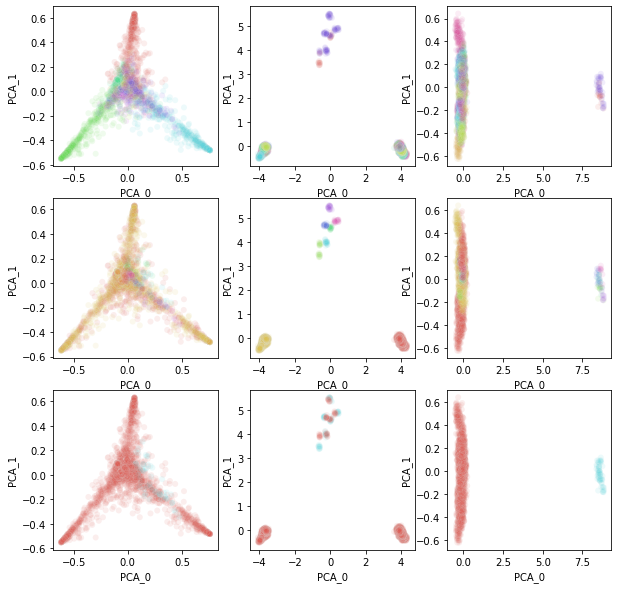

In [56]:
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data
idx_tmp = np.tile(idx_train, 2)[240:4240]

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
Y_temp = true_prop_df.columns[Y_temp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


print(f"Number unique Y: {len(np.unique(Y_temp))}")


z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)
prop_outputs = classifier.predict(X_temp, batch_size=batch_size)


# now concatenate together
z_concat = np.hstack([z_slack, prop_outputs, z_rot, z_drug])

# and decode
decoded_outputs = decoder.predict(z_concat, batch_size=batch_size)


fig, axs = plt.subplots(3, 3, figsize=(10,10))

plot_df = vp.get_pca_for_plotting(np.asarray(prop_outputs))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[0,0], title="")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[1,0], title="")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[2,0], title="")

plot_df = vp.get_pca_for_plotting(np.asarray(mu_rot))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[0,1], title="")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[1,1], title="")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[2,1], title="")

plot_df = vp.get_pca_for_plotting(np.asarray(mu_drug))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[0,2], title="")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[1,2], title="")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[2,2], title="")


#fig.suptitle("Training Data", fontsize=14)

fig.show()

out_plot = os.path.join(res_data_path, f"output1.pdf")
fig.savefig(out_plot, dpi=300)

for ax1 in axs:
    for ax2 in ax1:
        ax2.get_legend().remove()

    
out_plot = os.path.join(res_data_path, f"output2.pdf")
fig.savefig(out_plot, dpi=300)

In [76]:
# test values
idx_tmp = np.where(meta_df.isTraining=="Test")[0]
len_tmp = len(idx_tmp)
idx_tmp = np.tile(idx_tmp, 5)


X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]


z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)
prop_outputs = classifier.predict(X_temp, batch_size=batch_size)

# get back the unrepeated index
idx_tmp = idx_tmp[0:len_tmp]
prop_outputs = prop_outputs[0:len_tmp]
mu_rot = mu_rot[0:len_tmp]
mu_drug = mu_drug[0:len_tmp]


# get the other labels of interest

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
# make 1-hot
Y_temp_1hot = np.zeros((Y_temp.size, Y_temp.max() + 1))
Y_temp_1hot[np.arange(Y_temp.size), Y_temp] = 1

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
# make 1-hot
label_temp_1hot = np.zeros((label_temp.size, label_temp.max() + 1))
label_temp_1hot[np.arange(label_temp.size), label_temp] = 1


perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]
# make 1-hot
perturb_temp_1hot = np.zeros((perturb_temp.size, perturb_temp.max() + 1))
perturb_temp_1hot[np.arange(perturb_temp.size), perturb_temp] = 1


In [81]:
# NOW predict most abundant cell type
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit

def run_RF(X_in, Y_in):

    sss = StratifiedShuffleSplit(n_splits=2, test_size=100, random_state=0)
    _, index = sss.split(X_in, Y_in)
    x_rf_train, y_rf_train = X_in[index[1]], Y_in[index[1]]
    x_rf_test, y_rf_test = X_in[index[0]], Y_in[index[0]]

    clf = RandomForestClassifier(random_state=0)
    clf.fit(x_rf_train, y_rf_train)
    y_rf_pred = clf.predict(x_rf_test)
    out_f1 = np.median(f1_score(y_rf_test, y_rf_pred, average=None))

    return out_f1

########
## using prop_outputs
########

prop_y_f1 = run_RF(prop_outputs, Y_temp_1hot)
prop_lab_f1 = run_RF(prop_outputs, label_temp_1hot)
prop_pert_f1 = run_RF(prop_outputs, perturb_temp_1hot)

########
## using mu_rot
########

samp_y_f1 = run_RF(mu_rot, Y_temp_1hot)
samp_lab_f1 = run_RF(mu_rot, label_temp_1hot)
samp_pert_f1 = run_RF(mu_rot, perturb_temp_1hot)


########
## using mu_drug
########

drug_y_f1 = run_RF(mu_drug, Y_temp_1hot)
drug_lab_f1 = run_RF(mu_drug, label_temp_1hot)
drug_pert_f1 = run_RF(mu_drug, perturb_temp_1hot)



/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [82]:
print(f"{prop_y_f1}, {prop_lab_f1}, {prop_pert_f1}")
print(f"{samp_y_f1}, {samp_lab_f1}, {samp_pert_f1}")
print(f"{drug_y_f1}, {drug_lab_f1}, {drug_pert_f1}")

0.9426759917136117, 0.19335075047384864, 0.6623049359585076


Number unique Y: 10
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:595: RuntimeWarning: divide by zero encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var.sum()


(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)


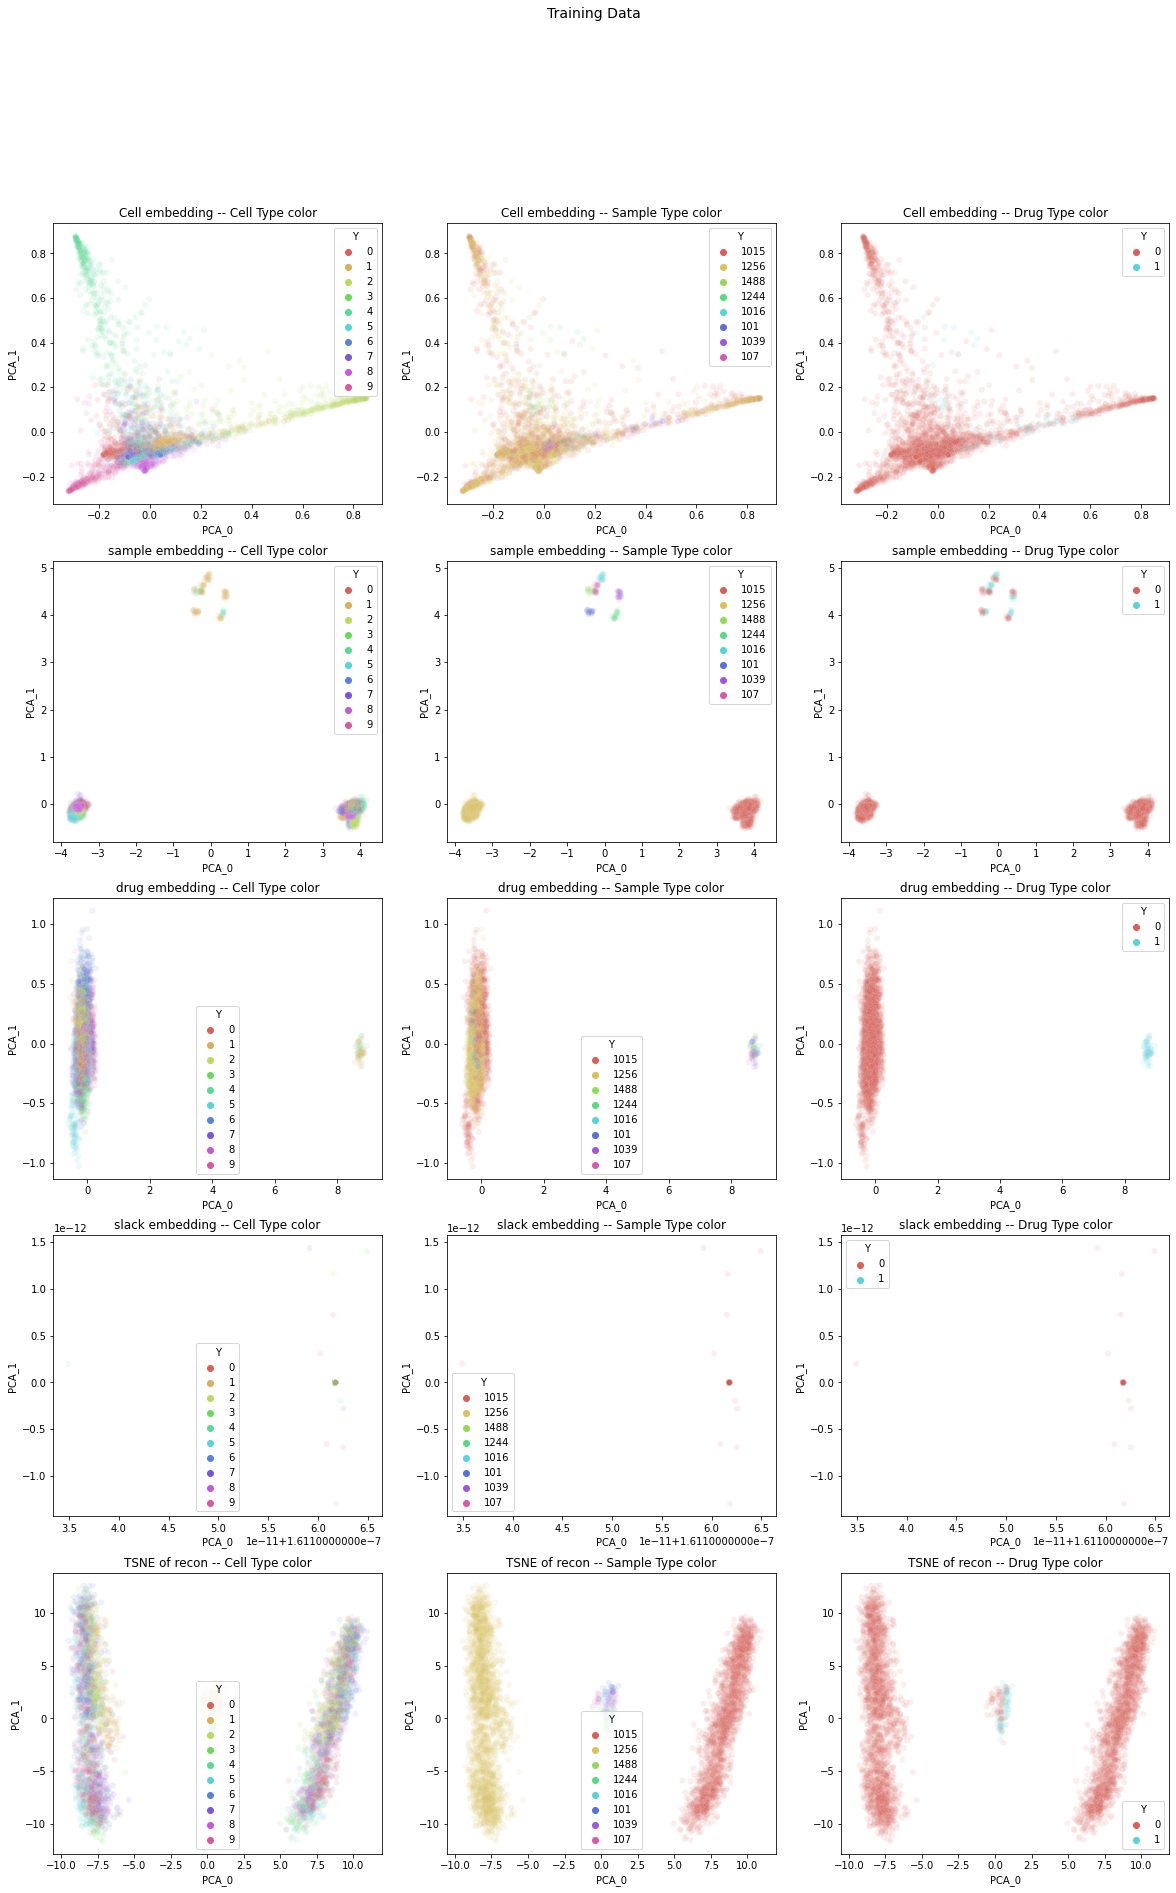

In [ ]:
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data
idx_tmp = np.tile(idx_train, 2)[240:4240]

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


print(f"Number unique Y: {len(np.unique(Y_temp))}")


z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)
prop_outputs = classifier.predict(X_temp, batch_size=batch_size)


# now concatenate together
z_concat = np.hstack([z_slack, prop_outputs, z_rot, z_drug])

# and decode
decoded_outputs = decoder.predict(z_concat, batch_size=batch_size)


fig, axs = plt.subplots(5, 3, figsize=(20,30))

plot_df = vp.get_pca_for_plotting(np.asarray(prop_outputs))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[0,2], title="Cell embedding -- Drug Type color")

plot_df = vp.get_pca_for_plotting(np.asarray(mu_rot))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[1,2], title="sample embedding -- Drug Type color")

plot_df = vp.get_pca_for_plotting(np.asarray(mu_drug))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[2,0], title="drug embedding -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[2,1], title="drug embedding -- Sample Type color")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[2,2], title="drug embedding -- Drug Type color")

plot_df = vp.get_pca_for_plotting(np.asarray(mu_slack))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[3,0], title="slack embedding -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[3,1], title="slack embedding -- Sample Type color")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[3,2], title="slack embedding -- Drug Type color")

plot_df = vp.get_pca_for_plotting(np.asarray(decoded_outputs))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[4,0], title="TSNE of recon -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[4,1], title="TSNE of recon -- Sample Type color")
vp.plot_pca(plot_df, color_vec=perturb_temp, ax=axs[4,2], title="TSNE of recon -- Drug Type color")




fig.suptitle("Training Data", fontsize=14)

fig.show()

## Do latent space projectsions

### drug perturbation

In [ ]:
sample_interest = ['1488', '1244', '1016', '101', '1039', '107']
sample_code_idx = np.logical_and(meta_df.isTraining == "Train", 
                                    np.isin(meta_df.sample_id, sample_interest))
sample_code_idx = np.logical_and(sample_code_idx, meta_df.stim == "STIM")
sample_code_idx = np.where(sample_code_idx)[0] 
sample_code_idx = np.repeat(sample_code_idx, 200)
a = meta_df.iloc[sample_code_idx]
a.sample_id.value_counts()

1488    2000
1244    2000
1016    2000
101     2000
1039    2000
107     2000
Name: sample_id, dtype: int64

In [ ]:

# get the training data
# so we can use it to get the latent codes
idx_train = np.where(meta_df.isTraining == "Train")[0]
train_meta_df = meta_df.iloc[idx_train]

X_temp = np.copy(X_full)

#####
# get cell type latent codes
#####
# the the codes for cell type proportion
sc_props = sc_preprocess.get_single_celltype_prop_matrix(num_samp=200, cell_order=Y_full.columns)
sc_props = np.tile(sc_props, (6,1))


#####
# get perturbation latent codes
#####

# get the index to get the perturbation latent codes
pert_code_idx = np.logical_and(meta_df.isTraining == "Train", meta_df.stim == "STIM")
pert_code_idx = np.where(pert_code_idx)[0] 
pert_code_idx = np.random.choice(pert_code_idx, 12000, replace=True)
z_slack, _, _, z_rot, _, _, z_pert, _, _ = encoder_unlab.predict(X_temp[pert_code_idx,], batch_size=batch_size)


# get the index to get the UNperturbed latent codes
unpert_code_idx = np.logical_and(meta_df.isTraining == "Train", meta_df.stim == "CTRL")
unpert_code_idx = np.where(unpert_code_idx)[0] 
unpert_code_idx = np.random.choice(unpert_code_idx, 12000, replace=True)
z_slack, _, _, z_rot, _, _, z_unpert, _, _ = encoder_unlab.predict(X_temp[unpert_code_idx,], batch_size=batch_size)

#####
# get sample latent codes
#####
# get the index to get the sample latent codes
sample_interest = ['1488', '1244', '1016', '101', '1039', '107']
sample_code_idx = np.logical_and(meta_df.isTraining == "Train", 
                                    np.isin(meta_df.sample_id, sample_interest))
sample_code_idx = np.logical_and(sample_code_idx, meta_df.stim == "CTRL")
sample_code_idx = np.where(sample_code_idx)[0] 
sample_code_idx = np.repeat(sample_code_idx, 200)

z_slack, _, _, z_samples, _, _, z_drug, _, _ = encoder_unlab.predict(X_temp[sample_code_idx,], batch_size=batch_size)


# make the metadata table 
temp_meta_df = meta_df.iloc[sample_code_idx]
temp_meta_df.isTraining = "Test"
temp_meta_df.cell_prop_type = "cell_type_specific"

prop_max = np.copy(sc_props)
prop_max = np.argmax(prop_max, axis=1)
prop_max = Y_full.columns[prop_max]
temp_meta_df.Y_max = prop_max

######
# now put it all together
######

# now concatenate together and add the stim codes to the latent
z_concat_unlab_perturb = np.hstack([z_slack, sc_props, z_samples, z_pert])
decoded_0_1 = decoder.predict(z_concat_unlab_perturb, batch_size=batch_size)
decoded_0_1 = scaler.inverse_transform(decoded_0_1)

# now concatenate together and add the stim codes to the latent
z_concat_unlab_perturb = np.hstack([z_slack, sc_props, z_samples, z_pert])
decoded_0_0 = decoder.predict(z_concat_unlab_perturb, batch_size=batch_size)
decoded_0_0 = scaler.inverse_transform(decoded_0_0)





<ipython-input-58-d64097ddba1b>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_meta_df.isTraining = "Test"
<ipython-input-58-d64097ddba1b>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_meta_df.cell_prop_type = "cell_type_specific"
<ipython-input-58-d64097ddba1b>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [ ]:

def calc_buddi_perturbation(meta_df, X_full, scaler, encoder_unlab, decoder, batch_size):

    # get the training data
    # so we can use it to get the latent codes
    idx_train = np.where(meta_df.isTraining == "Train")[0]
    train_meta_df = meta_df.iloc[idx_train]

    X_temp = np.copy(X_full)

    #####
    # get cell type latent codes
    #####
    # the the codes for cell type proportion
    sc_props = sc_preprocess.get_single_celltype_prop_matrix(num_samp=100, cell_order=Y_full.columns)
    sc_props = np.tile(sc_props, (6,1))


    #####
    # get perturbation latent codes
    #####

    # get the index to get the perturbation latent codes
    pert_code_idx = np.logical_and(meta_df.isTraining == "Train", meta_df.stim == "STIM")
    pert_code_idx = np.where(pert_code_idx)[0] 
    pert_code_idx = np.random.choice(pert_code_idx, 6000, replace=True)
    z_slack, _, _, z_rot, _, _, z_pert, _, _ = encoder_unlab.predict(X_temp[pert_code_idx,], batch_size=batch_size)


    # get the index to get the UNperturbed latent codes
    unpert_code_idx = np.logical_and(meta_df.isTraining == "Train", meta_df.stim == "CTRL")
    unpert_code_idx = np.where(unpert_code_idx)[0] 
    unpert_code_idx = np.random.choice(unpert_code_idx, 6000, replace=True)
    z_slack, _, _, z_rot, _, _, z_unpert, _, _ = encoder_unlab.predict(X_temp[unpert_code_idx,], batch_size=batch_size)

    #####
    # get sample latent codes
    #####
    # get the index to get the sample latent codes
    sample_interest = ['1488', '1244', '1016', '101', '1039', '107']
    sample_code_idx = np.logical_and(meta_df.isTraining == "Train", 
                                        np.isin(meta_df.sample_id, sample_interest))
    sample_code_idx = np.logical_and(sample_code_idx, meta_df.stim == "CTRL")
    sample_code_idx = np.where(sample_code_idx)[0] 
    sample_code_idx = np.repeat(sample_code_idx, 100)

    z_slack, _, _, z_samples, _, _, z_drug, _, _ = encoder_unlab.predict(X_temp[sample_code_idx,], batch_size=batch_size)


    # make the metadata table 
    temp_meta_df = meta_df.iloc[sample_code_idx]
    temp_meta_df.isTraining = "Test"
    temp_meta_df.cell_prop_type = "cell_type_specific"

    prop_max = np.copy(sc_props)
    prop_max = np.argmax(prop_max, axis=1)
    prop_max = Y_full.columns[prop_max]
    temp_meta_df.Y_max = prop_max

    ######
    # now put it all together
    ######

    # now concatenate together and add the stim codes to the latent
    z_concat_perturb = np.hstack([z_slack, sc_props, z_samples, z_pert])
    decoded_0_1 = decoder.predict(z_concat_perturb, batch_size=batch_size)
    decoded_0_1 = scaler.inverse_transform(decoded_0_1)

    # now concatenate together and add the stim codes to the latent
    z_concat_unperturb = np.hstack([z_slack, sc_props, z_samples, z_unpert])
    decoded_0_0 = decoder.predict(z_concat_unperturb, batch_size=batch_size)
    decoded_0_0 = scaler.inverse_transform(decoded_0_0)




    return (temp_meta_df, decoded_0_0, decoded_0_1)


In [ ]:
stim_test_meta_df, decoded_0_0, decoded_0_1 = calc_buddi_perturbation(meta_df, X_full, scaler, encoder_unlab, decoder, batch_size)


<ipython-input-59-53d4bdc04a30>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_meta_df.isTraining = "Test"
<ipython-input-59-53d4bdc04a30>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_meta_df.cell_prop_type = "cell_type_specific"
<ipython-input-59-53d4bdc04a30>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [ ]:
decoded_0_0.shape

(6000, 7068)

In [ ]:
stim_test_meta_df

sample_id  stim isTraining      cell_prop_type samp_type  Y_max
8       1488  CTRL       Test  cell_type_specific      bulk      B
8       1488  CTRL       Test  cell_type_specific      bulk      B
8       1488  CTRL       Test  cell_type_specific      bulk      B
8       1488  CTRL       Test  cell_type_specific      bulk      B
8       1488  CTRL       Test  cell_type_specific      bulk      B
..       ...   ...        ...                 ...       ...    ...
65       107  CTRL       Test  cell_type_specific      bulk  T_Act
65       107  CTRL       Test  cell_type_specific      bulk  T_Act
65       107  CTRL       Test  cell_type_specific      bulk  T_Act
65       107  CTRL       Test  cell_type_specific      bulk  T_Act
65       107  CTRL       Test  cell_type_specific      bulk  T_Act

[6000 rows x 6 columns]

In [ ]:
real_ctrl_idx = np.logical_and(meta_df.stim == "CTRL", meta_df.isTraining == "Test")
real_ctrl_idx = np.logical_and(real_ctrl_idx, meta_df.cell_prop_type == "cell_type_specific")
real_ctrl_idx = np.logical_and(real_ctrl_idx, meta_df.sample_id == "101")
real_ctrl_idx = np.logical_and(real_ctrl_idx, meta_df.Y_max == "B")
real_ctrl_idx = np.where(real_ctrl_idx)[0]
len(real_ctrl_idx)

100

In [ ]:
real_ctrl_idx = np.logical_and(stim_test_meta_df.stim == "CTRL", stim_test_meta_df.isTraining == "Test")
real_ctrl_idx = np.logical_and(real_ctrl_idx, stim_test_meta_df.cell_prop_type == "cell_type_specific")
real_ctrl_idx = np.logical_and(real_ctrl_idx, stim_test_meta_df.sample_id == "101")
real_ctrl_idx = np.logical_and(real_ctrl_idx, stim_test_meta_df.Y_max == "B")
real_ctrl_idx = np.where(real_ctrl_idx)[0]
len(real_ctrl_idx)

100

In [ ]:

# run first the cell_type specific things

cell_type_specific_r2 = None
cell_type_specific_real = None
cell_type_specific_proj = None
meta_DESeq = None
all_samps = ['101', '1016', '1039', '107', '1244', '1488']

ctrl_test_meta_df, decoded_0_0, decoded_0_1 = calc_buddi_perturbation(meta_df, X_full, scaler, encoder_unlab, decoder, batch_size)


for curr_samp in all_samps:
    print(curr_samp)
    for curr_cell_type in Y_full.columns:
        print(curr_cell_type)

        real_stim, real_ctrl, proj_stim, proj_ctrl = vp.subset_sample_celltype_perturbation(X_full, decoded_0_0, 
                                                                                        decoded_0_1, scaler, curr_samp, 
                                                                                        "cell_type_specific", 
                                                                                        meta_df, ctrl_test_meta_df,
                                                                                        curr_cell_type)

        expr_r2, log2FC_r2, log2FC_r2_bottom, log2FC_r2_mid, log2FC_r2_top, log2FC_rmse = vp.calc_expr_log2FC_r2(real_ctrl, real_stim, proj_ctrl, proj_stim)

        curr_res = [curr_samp, curr_cell_type, "cell_type_specific", expr_r2, log2FC_r2, log2FC_r2_bottom, log2FC_r2_mid, log2FC_r2_top, log2FC_rmse]
        curr_res = pd.DataFrame([curr_res],  columns = ['sample_id', 'cell_type', 'bulk_type', 
                                                        'expr_r2', 'log2FC_r2',
                                                        'log2FC_r2_bottom', 'log2FC_r2_mid', 'log2FC_r2_top', 'log2FC_rmse'])

        curr_meta = {'sample_id':[curr_samp]*(proj_stim.shape[0]*2),
                     'cell_type':[curr_cell_type]*(proj_stim.shape[0]*2),
                     'cond':['ctrl']*(proj_stim.shape[0]) + ['stim']*(proj_stim.shape[0])}
        curr_meta = pd.DataFrame(curr_meta)
        curr_DESeq_real = np.append(real_ctrl, real_stim, axis=0)
        curr_DESeq_proj = np.append(proj_ctrl, proj_stim, axis=0)

        if cell_type_specific_r2 is None:
            cell_type_specific_r2 = curr_res
            meta_DESeq = curr_meta
            cell_type_specific_real = curr_DESeq_real
            cell_type_specific_proj = curr_DESeq_proj
        else:
             cell_type_specific_r2 = pd.concat([cell_type_specific_r2, curr_res])
             meta_DESeq = pd.concat([meta_DESeq, curr_meta])
             cell_type_specific_real = np.append(cell_type_specific_real, curr_DESeq_real, axis=0)
             cell_type_specific_proj = np.append(cell_type_specific_proj, curr_DESeq_proj, axis=0)



# now run the realistic ones

<ipython-input-59-53d4bdc04a30>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_meta_df.isTraining = "Test"
<ipython-input-59-53d4bdc04a30>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_meta_df.cell_prop_type = "cell_type_specific"
<ipython-input-59-53d4bdc04a30>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

101
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1016
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1039
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
107
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1244
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1488
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act


In [ ]:
cell_type_specific_r2

sample_id    cell_type           bulk_type   expr_r2  log2FC_r2  \
0       101            B  cell_type_specific  0.766198   0.765586   
0       101    CD14_Mono  cell_type_specific  0.922716   0.631599   
0       101    CD16_Mono  cell_type_specific  0.862500   0.763880   
0       101    CD4_Mem_T  cell_type_specific  0.782020   0.781648   
0       101  CD4_Naive_T  cell_type_specific  0.648166   0.757004   
0       101        CD8_T  cell_type_specific  0.713852   0.770233   
0       101           DC  cell_type_specific  0.781315   0.728145   
0       101           Mk  cell_type_specific  0.585811   0.740740   
0       101           NK  cell_type_specific  0.678972   0.751865   
0       101        T_Act  cell_type_specific  0.733422   0.760729   
0      1016            B  cell_type_specific  0.782132   0.783577   
0      1016    CD14_Mono  cell_type_specific  0.943525   0.697265   
0      1016    CD16_Mono  cell_type_specific  0.855275   0.769670   
0      1016    CD4_Mem_T  cell_type_specific  0.805008   0.785513   
0      1016  CD4_Naive_T  cell_type_specific  0.788964   0.767592   
0      1016        CD8_T  cell_type_specific  0.818337   0.802699   
0      1016           DC  cell_type_specific  0.774971   0.747326   
0      1016           Mk  cell_type_specific  0.640959   0.774400   
0      1016           NK  cell_type_specific  0.687499   0.799146   
0      1016        T_Act  cell_type_specific  0.760745   0.763663   
0      1039            B  cell_type_specific  0.701165   0.752160   
0      1039    CD14_Mono  cell_type_specific  0.901984   0.560072   
0      1039    CD16_Mono  cell_type_specific  0.753279   0.702713   
0      1039    CD4_Mem_T  cell_type_specific  0.806500   0.748369   
0      1039  CD4_Naive_T  cell_type_specific  0.769912   0.723140   
0      1039        CD8_T  cell_type_specific  0.672390   0.742678   
0      1039           DC  cell_type_specific  0.731272   0.720383   
0      1039           Mk  cell_type_specific  0.597504   0.709118   
0      1039           NK  cell_type_specific  0.659214   0.725277   
0      1039        T_Act  cell_type_specific  0.647501   0.732461   
0       107            B  cell_type_specific  0.700111   0.697299   
0       107    CD14_Mono  cell_type_specific  0.902847   0.573605   
0       107    CD16_Mono  cell_type_specific  0.768137   0.671216   
0       107    CD4_Mem_T  cell_type_specific  0.760658   0.717134   
0       107  CD4_Naive_T  cell_type_specific  0.709917   0.699837   
0       107        CD8_T  cell_type_specific  0.589913   0.708630   
0       107           DC  cell_type_specific  0.724046   0.663912   
0       107           Mk  cell_type_specific  0.589198   0.694872   
0       107           NK  cell_type_specific  0.648078   0.689952   
0       107        T_Act  cell_type_specific  0.528278   0.685505   
0      1244            B  cell_type_specific  0.810003   0.813868   
0      1244    CD14_Mono  cell_type_specific  0.892325   0.693891   
0      1244    CD16_Mono  cell_type_specific  0.806749   0.731795   
0      1244    CD4_Mem_T  cell_type_specific  0.872555   0.830240   
0      1244  CD4_Naive_T  cell_type_specific  0.904408   0.848393   
0      1244        CD8_T  cell_type_specific  0.791713   0.809875   
0      1244           DC  cell_type_specific  0.834182   0.714678   
0      1244           Mk  cell_type_specific  0.682957   0.790203   
0      1244           NK  cell_type_specific  0.755951   0.782602   
0      1244        T_Act  cell_type_specific  0.745786   0.784639   
0      1488            B  cell_type_specific  0.829439   0.824183   
0      1488    CD14_Mono  cell_type_specific  0.884370   0.660520   
0      1488    CD16_Mono  cell_type_specific  0.841810   0.740928   
0      1488    CD4_Mem_T  cell_type_specific  0.865459   0.852154   
0      1488  CD4_Naive_T  cell_type_specific  0.894396   0.834926   
0      1488        CD8_T  cell_type_specific  0.750873   0.835008   
0      1488           DC  cell_type_specific  0.807303   0.743150   


In [ ]:
pearson_res_file = os.path.join(res_data_path, f"{exp_id}_pearson_matr.csv")
cell_type_specific_r2.to_csv(pearson_res_file, index=False)


# Diff Expr

In [ ]:
def get_cell_type_DE(meta_DESeq, de_proj, de_real, cell_type_interest, TP_max=3, TN_min=1.25):
    # get the index of the cell type of interest
    cell_idx = np.where(meta_DESeq.cell_type == cell_type_interest)[0]
    de_proj_cell = de_proj.iloc[cell_idx,]
    de_real_cell = de_real.iloc[cell_idx,]
    meta_DESeq_cell = meta_DESeq.iloc[cell_idx,]

    # reindex so that anndata obj can be created easily
    new_index = ["samp_" + str(s) for s in range(len(cell_idx))]
    de_proj_cell.index = new_index
    meta_DESeq_cell.index = new_index
    de_real_cell.index = new_index

    # run deseq for projection
    dds_proj_cell = DeseqDataSet(
        counts=de_proj_cell,
        clinical=meta_DESeq_cell,
        design_factors=["cond", "sample_id"],
        refit_cooks=True
    )

    dds_proj_cell.deseq2()
    cell_proj_res = DeseqStats(dds_proj_cell, contrast=["cond", "ctrl", "stim"])
    cell_proj_res.summary()

    # run deseq for real data
    dds_real_cell = DeseqDataSet(
        counts=de_real_cell,
        clinical=meta_DESeq_cell,
        design_factors=["cond", "sample_id"],
        refit_cooks=True
    )

    dds_real_cell.deseq2()
    cell_real_res = DeseqStats(dds_real_cell, contrast=["cond", "ctrl", "stim"])
    cell_real_res.summary()

    # now get the TP and TN

    # get the DESeq res matrix
    cell_real_res_df = cell_real_res.results_df
    cell_proj_res_df = cell_proj_res.results_df


    # get the "true positives"
    real_TP = cell_real_res_df.iloc[np.where(np.abs(cell_real_res_df.log2FoldChange) > TP_max)[0]]
    real_TP_list = real_TP.index.to_list()

    proj_TP = cell_proj_res_df.iloc[np.where(np.abs(cell_proj_res_df.log2FoldChange) > TP_max)[0]]
    proj_TP_list = proj_TP.index.to_list()

    # get the "true negatives"
    real_TN = cell_real_res_df.iloc[np.where(np.abs(cell_real_res_df.log2FoldChange) < TN_min)[0]]
    real_TN_list = real_TN.index.to_list()

    proj_TN = cell_proj_res_df.iloc[np.where(np.abs(cell_proj_res_df.log2FoldChange) < TN_min)[0]]
    proj_TN_list = proj_TN.index.to_list()


    return (real_TP_list, proj_TP_list, real_TN_list, proj_TN_list)

In [ ]:
true_pos = len(np.intersect1d(real_TP_list, proj_TP_list))
false_pos = len(np.setdiff1d(proj_TP_list, real_TP_list))
true_neg = len(np.intersect1d(real_TN_list, proj_TN_list))
false_neg = len(np.setdiff1d(real_TP_list, proj_TP_list))

NameError: name 'real_TP_list' is not defined

In [ ]:
true_pos/(true_pos+false_neg)

0.6666666666666666

In [ ]:
true_neg/(true_neg+false_pos)

0.9929597701149425

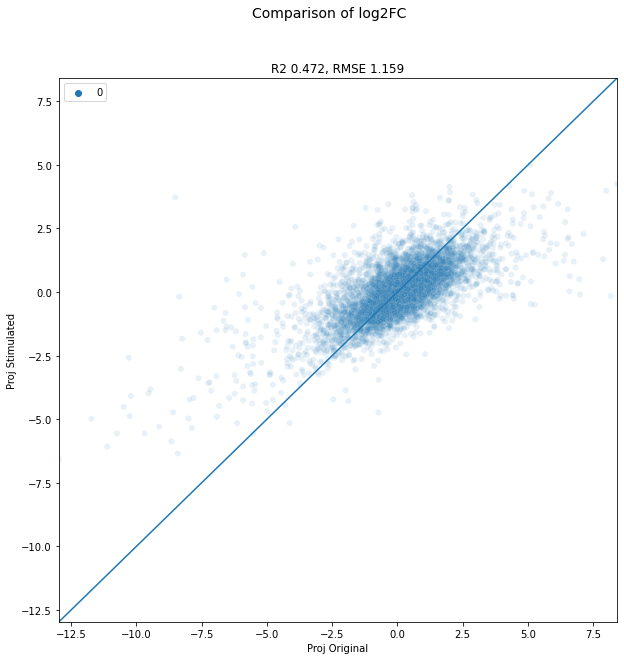

In [ ]:
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error

class_color = [0]*len(b_real_res_df.log2FoldChange)

fig, axs = plt.subplots(1, 1, figsize=(10,10))

real_log2FC = b_real_res_df.log2FoldChange
proj_log2FC = b_proj_res_df.log2FoldChange

a = real_log2FC
b = proj_log2FC
nas = np.logical_or(np.isnan(a), np.isnan(b))

r2_log2FC = np.round(r2_score(a[~nas], b[~nas]), 3)
rmse_log2FC = np.round(np.sqrt(mean_squared_error(a[~nas], b[~nas])), 3)

max_val = np.max([np.max(real_log2FC), np.max(proj_log2FC)])
min_val = np.min([np.min(real_log2FC), np.min(proj_log2FC)])
vp.plot_expr_corr(real_log2FC, proj_log2FC, axs, 
                    title=f"R2 {r2_log2FC}, RMSE {rmse_log2FC}", 
                    xlab="Proj Original", ylab="Proj Stimulated", 
                    class_id=class_color, max_val=max_val, min_val=min_val, alpha=0.1)


fig.suptitle("Comparison of log2FC", fontsize=14)

fig.show()


In [ ]:

# get the DE for each cell type

DE_res_dict = {}


for curr_cell_type in Y_full.columns:
    print(curr_cell_type)

    real_TP_list, proj_TP_list, real_TN_list, proj_TN_list =  get_cell_type_DE(meta_DESeq, de_proj, 
                                                                                de_real, 
                                                                                cell_type_interest=curr_cell_type, 
                                                                                TP_max=3, TN_min=3)
    

    true_pos = (real_TP_list, proj_TP_list)
    false_pos = np.setdiff1d(proj_TP_list, real_TP_list)
    true_neg = real_TN_list

    DE_res_dict[f"real_TP_{curr_cell_type}"] = real_TP_list
    DE_res_dict[f"real_TN_{curr_cell_type}"] = real_TP_list
    DE_res_dict[f"real_TP_{curr_cell_type}"] = real_TP_list
    DE_res_dict[f"real_TP_{curr_cell_type}"] = real_TP_list
    



# now run the realistic ones

B
Fitting size factors...
... done in 0.98 seconds.

Fitting dispersions...
... done in 6.84 seconds.

Fitting dispersion trend curve...
... done in 3.72 seconds.



/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pydeseq2/dds.py:522: RuntimeWarning: invalid value encountered in log
  ) - np.log(self[:, self.non_zero_genes].varm["fitted_dispersions"])
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/lib/utils.py:1054: ImplicitModificationWarning: Trying to modify attribute `.varm` of view, initializing view as actual.
  result[n] = np.nan


Fitting MAP dispersions...
... done in 6.08 seconds.

Fitting LFCs...


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pydeseq2/dds.py:587: RuntimeWarning: invalid value encountered in log
  self.varm["_outlier_genes"] = np.log(self.varm["genewise_dispersions"]) > np.log(


... done in 8.21 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 7.43 seconds.

Log2 fold change & Wald test p-value: cond ctrl vs stim


baseMean  log2FoldChange     lfcSE       stat         pvalue  \
7SK.2           3.910923        2.227432  0.061249  36.366720  1.430089e-289   
A2M             9.173788        0.824994  0.050591  16.307081   8.789384e-60   
A2M-AS1         6.246660       -0.105300  0.042244  -2.492632   1.268002e-02   
A4GALT         21.790943       -0.639490  0.043190 -14.806290   1.334029e-49   
AAAS           98.866952        0.344462  0.037113   9.281374   1.673071e-20   
...                  ...             ...       ...        ...            ...   
ZWILCH         60.591712        0.981651  0.033541  29.267357  2.700583e-188   
ZXDC          119.999639       -0.744283  0.031926 -23.312892  3.280905e-120   
ZYX           320.357350        1.083990  0.055525  19.522481   7.072013e-85   
ZZZ3          120.779004       -0.688556  0.030956 -22.243141  1.314257e-109   
hsa-mir-8072   18.251246        1.695172  0.040536  41.819181   0.000000e+00   

                       padj  
7SK.2         1.056054e-288  
A2M            1.840977e-59  
A2M-AS1        1.394703e-02  
A4GALT         2.572329e-49  
AAAS           2.439866e-20  
...                     ...  
ZWILCH        1.270641e-187  
ZXDC          1.057763e-119  
ZYX            1.769756e-84  
ZZZ3          3.948917e-109  
hsa-mir-8072   0.000000e+00  

[7067 rows x 6 columns]

Fitting size factors...
... done in 0.50 seconds.

Fitting dispersions...
... done in 5.60 seconds.

Fitting dispersion trend curve...
... done in 3.71 seconds.

Fitting MAP dispersions...
... done in 5.57 seconds.

Fitting LFCs...
... done in 9.00 seconds.

Refitting 9 outliers.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.09 seconds.

Running Wald tests...
... done in 7.49 seconds.

Log2 fold change & Wald test p-value: cond ctrl vs stim


baseMean  log2FoldChange     lfcSE       stat        pvalue  \
7SK.2           0.556164        1.240612  0.340645   3.641947  2.705837e-04   
A2M             1.989144        0.572815  0.189853   3.017160  2.551549e-03   
A2M-AS1         0.833555        0.131568  0.195261   0.673806  5.004345e-01   
A4GALT        105.480243        0.501504  0.142726   3.513762  4.418091e-04   
AAAS          381.083084        0.606283  0.062445   9.709071  2.758393e-22   
...                  ...             ...       ...        ...           ...   
ZWILCH        385.116694        0.643996  0.053161  12.113949  8.909897e-34   
ZXDC           10.833720       -0.782281  0.124843  -6.266126  3.701403e-10   
ZYX           291.917757        1.223979  0.075157  16.285673  1.247492e-59   
ZZZ3           68.326214       -0.308515  0.094270  -3.272680  1.065330e-03   
hsa-mir-8072   72.188751        0.775058  0.066421  11.668909  1.837655e-31   

                      padj  
7SK.2         3.758374e-04  
A2M           3.339682e-03  
A2M-AS1       5.292899e-01  
A4GALT        6.056308e-04  
AAAS          7.250603e-22  
...                    ...  
ZWILCH        3.070521e-33  
ZXDC          6.693641e-10  
ZYX           7.101185e-59  
ZZZ3          1.425521e-03  
hsa-mir-8072  6.056143e-31  

[7067 rows x 6 columns]

CD14_Mono
Fitting size factors...
... done in 1.00 seconds.



KeyboardInterrupt: 

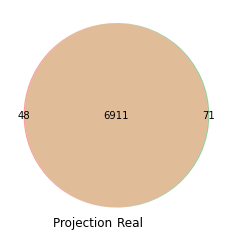

In [ ]:
venn2([set(real_TN_list), set(proj_TN_list)], set_labels = ('Projection ', 'Real '))
plt.show()

In [ ]:
# get the cell type specific expression
# and format it for DESeq

de_proj = pd.DataFrame(cell_type_specific_proj, columns = union_genes)
de_real = pd.DataFrame(cell_type_specific_real, columns = union_genes)

de_proj = de_proj.apply(np.ceil)
de_proj = de_proj.apply(pd.to_numeric)

de_real = de_real.apply(np.ceil)
de_real = de_real.apply(pd.to_numeric)


real_TP_list, proj_TP_list, real_TN_list, proj_TN_list =  get_cell_type_DE(meta_DESeq, de_proj, 
                                                                           de_real, cell_type_interest="B", 
                                                                           TP_max=3, TN_min=3)



Fitting size factors...
... done in 0.97 seconds.

Fitting dispersions...
... done in 6.84 seconds.

Fitting dispersion trend curve...
... done in 3.77 seconds.



/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pydeseq2/dds.py:522: RuntimeWarning: invalid value encountered in log
  ) - np.log(self[:, self.non_zero_genes].varm["fitted_dispersions"])
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/lib/utils.py:1054: ImplicitModificationWarning: Trying to modify attribute `.varm` of view, initializing view as actual.
  result[n] = np.nan


Fitting MAP dispersions...
... done in 6.18 seconds.

Fitting LFCs...


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pydeseq2/dds.py:587: RuntimeWarning: invalid value encountered in log
  self.varm["_outlier_genes"] = np.log(self.varm["genewise_dispersions"]) > np.log(


... done in 9.05 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 7.21 seconds.

Log2 fold change & Wald test p-value: cond ctrl vs stim


baseMean  log2FoldChange     lfcSE       stat         pvalue  \
7SK.2           3.910923        2.227432  0.061249  36.366720  1.430089e-289   
A2M             9.173788        0.824994  0.050591  16.307081   8.789384e-60   
A2M-AS1         6.246660       -0.105300  0.042244  -2.492632   1.268002e-02   
A4GALT         21.790943       -0.639490  0.043190 -14.806290   1.334029e-49   
AAAS           98.866952        0.344462  0.037113   9.281374   1.673071e-20   
...                  ...             ...       ...        ...            ...   
ZWILCH         60.591712        0.981651  0.033541  29.267357  2.700583e-188   
ZXDC          119.999639       -0.744283  0.031926 -23.312892  3.280905e-120   
ZYX           320.357350        1.083990  0.055525  19.522481   7.072013e-85   
ZZZ3          120.779004       -0.688556  0.030956 -22.243141  1.314257e-109   
hsa-mir-8072   18.251246        1.695172  0.040536  41.819181   0.000000e+00   

                       padj  
7SK.2         1.056054e-288  
A2M            1.840977e-59  
A2M-AS1        1.394703e-02  
A4GALT         2.572329e-49  
AAAS           2.439866e-20  
...                     ...  
ZWILCH        1.270641e-187  
ZXDC          1.057763e-119  
ZYX            1.769756e-84  
ZZZ3          3.948917e-109  
hsa-mir-8072   0.000000e+00  

[7067 rows x 6 columns]

Fitting size factors...
... done in 0.50 seconds.

Fitting dispersions...
... done in 5.25 seconds.

Fitting dispersion trend curve...
... done in 3.72 seconds.

Fitting MAP dispersions...
... done in 5.43 seconds.

Fitting LFCs...
... done in 9.11 seconds.

Refitting 9 outliers.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.10 seconds.

Running Wald tests...
... done in 7.33 seconds.

Log2 fold change & Wald test p-value: cond ctrl vs stim


baseMean  log2FoldChange     lfcSE       stat        pvalue  \
7SK.2           0.556164        1.240612  0.340645   3.641947  2.705837e-04   
A2M             1.989144        0.572815  0.189853   3.017160  2.551549e-03   
A2M-AS1         0.833555        0.131568  0.195261   0.673806  5.004345e-01   
A4GALT        105.480243        0.501504  0.142726   3.513762  4.418091e-04   
AAAS          381.083084        0.606283  0.062445   9.709071  2.758393e-22   
...                  ...             ...       ...        ...           ...   
ZWILCH        385.116694        0.643996  0.053161  12.113949  8.909897e-34   
ZXDC           10.833720       -0.782281  0.124843  -6.266126  3.701403e-10   
ZYX           291.917757        1.223979  0.075157  16.285673  1.247492e-59   
ZZZ3           68.326214       -0.308515  0.094270  -3.272680  1.065330e-03   
hsa-mir-8072   72.188751        0.775058  0.066421  11.668909  1.837655e-31   

                      padj  
7SK.2         3.758374e-04  
A2M           3.339682e-03  
A2M-AS1       5.292899e-01  
A4GALT        6.056308e-04  
AAAS          7.250603e-22  
...                    ...  
ZWILCH        3.070521e-33  
ZXDC          6.693641e-10  
ZYX           7.101185e-59  
ZZZ3          1.425521e-03  
hsa-mir-8072  6.056143e-31  

[7067 rows x 6 columns]

In [ ]:
de_real

7SK.2  A2M  A2M-AS1  A4GALT    AAAS  AAED1   AAK1   AAMDC    AAMP  \
0        0.0  0.0      0.0     0.0  1266.0  151.0  469.0  1016.0  1049.0   
1        0.0  0.0      0.0     0.0  1731.0  156.0  495.0   856.0  1133.0   
2        0.0  0.0      0.0     0.0  1299.0  171.0  490.0   590.0  1122.0   
3        0.0  0.0      0.0     4.0  1867.0  170.0  391.0   983.0   827.0   
4        5.0  0.0      0.0     4.0  1470.0  165.0  430.0   817.0  1096.0   
...      ...  ...      ...     ...     ...    ...    ...     ...     ...   
11995    0.0  1.0      0.0     0.0    12.0   47.0  645.0     6.0   241.0   
11996    0.0  0.0      0.0     0.0    12.0   23.0  740.0     0.0   223.0   
11997    0.0  0.0      0.0     0.0     6.0   40.0  631.0     0.0   141.0   
11998    0.0  0.0      0.0     0.0     6.0   67.0  904.0     8.0   348.0   
11999    0.0  7.0      0.0     0.0    54.0  395.0  547.0    16.0   799.0   

       AAR2  ...  ZSWIM3  ZSWIM4  ZSWIM6  ZSWIM8   ZW10  ZWILCH  ZXDC    ZYX  \
0       8.0  ...     0.0    42.0   509.0     4.0   21.0   319.0   0.0  113.0   
1      22.0  ...     0.0    20.0   539.0     7.0  186.0   470.0   0.0   99.0   
2       3.0  ...     0.0    92.0   426.0    43.0   13.0   244.0   0.0   99.0   
3       2.0  ...     0.0    61.0   411.0     9.0    9.0   343.0   0.0  105.0   
4       5.0  ...     0.0     4.0   520.0    21.0   24.0   280.0   0.0  128.0   
...     ...  ...     ...     ...     ...     ...    ...     ...   ...    ...   
11995  47.0  ...     6.0     0.0     0.0     2.0    3.0     8.0  31.0   53.0   
11996  29.0  ...     7.0     0.0     0.0     0.0    0.0     0.0   0.0  126.0   
11997  39.0  ...     0.0     3.0     0.0     0.0    0.0     1.0   7.0   96.0   
11998  35.0  ...     0.0     3.0     0.0     2.0    3.0     0.0   5.0  198.0   
11999  36.0  ...    31.0     9.0     0.0     4.0    5.0     1.0  94.0  598.0   

         ZZZ3  hsa-mir-8072  
0         0.0         311.0  
1         0.0         340.0  
2         0.0         336.0  
3         0.0         315.0  
4         0.0         282.0  
...       ...           ...  
11995  1048.0           0.0  
11996  1251.0           0.0  
11997  1431.0           0.0  
11998  1143.0           0.0  
11999   906.0           0.0  

[12000 rows x 7067 columns]

In [ ]:
b_idx = np.where(meta_DESeq.cell_type == "CD14_Mono")[0]
de_proj_b = de_proj.iloc[b_idx,]
meta_DESeq_b = meta_DESeq.iloc[b_idx,]

new_index = ["samp_" + str(s) for s in range(len(b_idx))]
de_proj_b.index = new_index
meta_DESeq_b.index = new_index




In [ ]:
dds_proj_B = DeseqDataSet(
    counts=de_proj_b,
    clinical=meta_DESeq_b,
    design_factors=["cond", "sample_id"],
    refit_cooks=True
)

dds_proj_B.deseq2()

b_proj_res = DeseqStats(dds_proj_B, contrast=["cond", "ctrl", "stim"])

b_proj_res.summary()

Fitting size factors...
... done in 0.99 seconds.

Fitting dispersions...
... done in 7.30 seconds.

Fitting dispersion trend curve...
... done in 4.59 seconds.

Fitting MAP dispersions...


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pydeseq2/dds.py:522: RuntimeWarning: invalid value encountered in log
  ) - np.log(self[:, self.non_zero_genes].varm["fitted_dispersions"])


... done in 6.28 seconds.

Fitting LFCs...


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pydeseq2/dds.py:587: RuntimeWarning: invalid value encountered in log
  self.varm["_outlier_genes"] = np.log(self.varm["genewise_dispersions"]) > np.log(


... done in 8.58 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 7.51 seconds.

Log2 fold change & Wald test p-value: cond ctrl vs stim


baseMean  log2FoldChange     lfcSE       stat         pvalue  \
7SK.2           2.113459        1.191381  0.063056  18.894136   1.274572e-79   
A2M            12.623193        1.472886  0.054256  27.147094  2.740152e-162   
A2M-AS1         3.981224       -0.109600  0.045618  -2.402528   1.628218e-02   
A4GALT         24.811071       -0.137043  0.043034  -3.184530   1.449893e-03   
AAAS          102.955233        0.474075  0.036307  13.057533   5.756272e-39   
...                  ...             ...       ...        ...            ...   
ZWILCH         37.988053        0.451205  0.031870  14.157772   1.672123e-45   
ZXDC           74.085708       -1.233219  0.034295 -35.959039  3.656084e-283   
ZYX           929.724278        1.045100  0.034181  30.575540  2.588427e-205   
ZZZ3          107.047033       -0.160282  0.031974  -5.012947   5.360270e-07   
hsa-mir-8072   17.323208        2.075015  0.041420  50.096914   0.000000e+00   

                       padj  
7SK.2          3.037910e-79  
A2M           1.068690e-161  
A2M-AS1        1.778182e-02  
A4GALT         1.627962e-03  
AAAS           9.968041e-39  
...                     ...  
ZWILCH         3.088576e-45  
ZXDC          2.660921e-282  
ZYX           1.360031e-204  
ZZZ3           6.440161e-07  
hsa-mir-8072   0.000000e+00  

[7067 rows x 6 columns]

In [ ]:
de_real_b = de_real.iloc[b_idx,]
de_real_b.index = new_index


dds_real_B = DeseqDataSet(
    counts=de_real_b,
    clinical=meta_DESeq_b,
    design_factors=["cond", "sample_id"],
    refit_cooks=True
)

dds_real_B.deseq2()

b_real_res = DeseqStats(dds_real_B, contrast=["cond", "ctrl", "stim"])

b_real_res.summary()


Fitting size factors...
... done in 0.62 seconds.

Fitting dispersions...
... done in 5.39 seconds.

Fitting dispersion trend curve...
... done in 3.81 seconds.

Fitting MAP dispersions...
... done in 5.88 seconds.

Fitting LFCs...
... done in 9.84 seconds.

Refitting 5 outliers.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Running Wald tests...
... done in 7.57 seconds.

Log2 fold change & Wald test p-value: cond ctrl vs stim


baseMean  log2FoldChange     lfcSE       stat         pvalue  \
7SK.2          26.335435        1.817295  0.253142   7.178953   7.024745e-13   
A2M             1.970145        0.437288  0.179457   2.436725   1.482094e-02   
A2M-AS1         0.847678        0.022652  0.221227   0.102392   9.184453e-01   
A4GALT         45.656358        3.954983  0.126181  31.343663  1.186930e-215   
AAAS           86.684320        2.061334  0.077230  26.690874  6.007256e-157   
...                  ...             ...       ...        ...            ...   
ZWILCH         18.484149        0.372171  0.108446   3.431850   5.994788e-04   
ZXDC          131.819760       -0.857097  0.116700  -7.344425   2.066450e-13   
ZYX           898.839857        1.249656  0.055087  22.685132  6.281796e-114   
ZZZ3           56.047731       -1.577858  0.108973 -14.479293   1.637719e-47   
hsa-mir-8072   10.287655        0.642836  0.112412   5.718584   1.074153e-08   

                       padj  
7SK.2          1.044183e-12  
A2M            1.705040e-02  
A2M-AS1        9.237138e-01  
A4GALT        8.563722e-215  
AAAS          3.235706e-156  
...                     ...  
ZWILCH         7.291192e-04  
ZXDC           3.099895e-13  
ZYX           2.547961e-113  
ZZZ3           3.689470e-47  
hsa-mir-8072   1.474464e-08  

[7067 rows x 6 columns]

In [ ]:
a = np.array(b_proj_res.results_df.log2FoldChange)
b = b_real_res.results_df.log2FoldChange
nas = np.logical_or(np.isnan(a), np.isnan(b))
pearsonr(a[~nas], b[~nas])


(0.6881940796377121, 0.0)

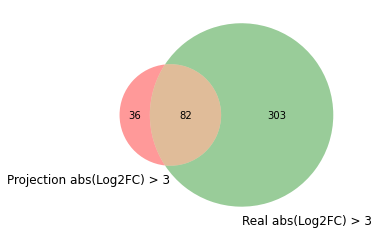

In [ ]:
b_real_res_df = b_real_res.results_df
b_proj_res_df = b_proj_res.results_df

b_real_res_df = b_real_res_df.sort_values(by=['log2FoldChange'])
a = b_real_res_df.iloc[np.where(np.abs(b_real_res_df.log2FoldChange) > 3)[0]]
b_real_res_list = a.index.to_list()

b_proj_res_df = b_proj_res_df.sort_values(by=['log2FoldChange'])
a = b_proj_res_df.iloc[np.where(np.abs(b_proj_res_df.log2FoldChange) > 3)[0]]

b_proj_res_list = a.index.to_list()


venn2([set(b_proj_res_list), set(b_real_res_list)], set_labels = ('Projection abs(Log2FC) > 3', 'Real abs(Log2FC) > 3'))
plt.show()

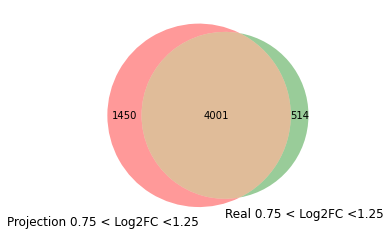

In [ ]:
b_real_res_df = b_real_res.results_df
b_proj_res_df = b_proj_res.results_df


fc_idx = np.where(np.logical_and(b_real_res_df.log2FoldChange <1.25,  
                                 b_real_res_df.log2FoldChange >0.75))[0]
fc_idx = np.where(np.abs(b_real_res_df.log2FoldChange) < 1.1)[0]
a = b_real_res_df.iloc[fc_idx]
b_real_res_list = a.index.to_list()


fc_idx = np.where(np.logical_and(b_proj_res_df.log2FoldChange <1.25,  
                                 b_proj_res_df.log2FoldChange >0.75))[0]
fc_idx = np.where(np.abs(b_proj_res_df.log2FoldChange) < 1.1)[0]
a = b_proj_res_df.iloc[fc_idx]
b_proj_res_list = a.index.to_list()


venn2([set(b_proj_res_list), set(b_real_res_list)], set_labels = ('Projection 0.75 < Log2FC <1.25', 'Real 0.75 < Log2FC <1.25'))
plt.show()